# Notebook Description

### This notebook contains the **Dimensionality Reduction** portion of our project.

The data being analyzed is ...

For *data_with_features.csv*
- Features: ['r1', 'r2', 'shaft_length', 'theta1', 'theta2', 'torsion']
- Labels: [**'rcat'**]

For *data_with_features3.csv*
- Features:['Fa_theta_plus', 'Fa_theta_minus', 'Fa_torsion', 'Fa_len_plus', 'Fa_len_minus', 'Fb_theta_plus', 'Fb_theta_minus', 'Fb_torsion', 'Fb_len_plus', 'Fb_len_minus', 'O_theta_plus', 'O_theta_minus', 'O_torsion', 'O_len_plus', 'O_len_minus', 'center_torsion_plus', 'center_torsion_minus', 'center_height', 'center_r_plus', 'center_r_minus']
- Labels: [**'rcat'**]

The methods utilized are: KPCovR (per original paper); PCA; Kernel PCA; tSNE; UMAP

## Installations and Imports

### Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install skmatter
!pip install umap-learn
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.1 MB/s eta 0:00:00


In [4]:
# Standard Imports
import os
import sys
import numpy as np
import pandas as pd
import glob

# Plotting Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
mpl.rcParams['figure.dpi'] = 120
import seaborn as sns

# Dimensionality Reduction Imports
from skmatter.preprocessing import StandardFlexibleScaler
from skmatter.decomposition import KernelPCovR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

import umap
import datashader
import bokeh
import holoviews
import umap.plot

matches = glob.glob("/content/drive/MyDrive/**/CDS_Group_Project", recursive=True) # I had to add a shortcut in google drive to this CDS_Group_Project drive since I am not the original owner and it was shared with me in order for this to work
if matches:
    BASE_DIR = matches[0]
else:
    raise FileNotFoundError("SharedProject folder not found in your Google Drive.")

data_dir = os.path.join(BASE_DIR, "Python_Notebooks/Group8_CDS_Data")

/usr/local/lib/python3.12/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.12/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.12/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)


### Data

#### *data_with_features.csv*

In [5]:
raw_df_v1 = pd.read_csv(f'{data_dir}/data_with_features.csv', index_col = 0)
raw_df_v1.describe()

k2           K1           rAC          rcat      kg(473K)  \
count  3.880000e+02   388.000000  3.880000e+02  3.880000e+02  3.880000e+02   
mean   1.934044e+07    37.930356  8.957118e+05  4.660473e+05  1.976712e+01   
std    1.814001e+08   466.250015  8.974441e+06  4.002405e+06  2.699537e+01   
min    2.085212e+02     0.000515  8.443474e+00  8.443473e+00  6.280091e-26   
25%    4.391391e+03     0.205611  1.619639e+03  1.619606e+03  5.391173e-02   
50%    8.521477e+03     0.920636  3.730133e+03  3.729963e+03  9.948799e+00   
75%    2.941931e+04     4.628069  9.654834e+03  9.653691e+03  3.210362e+01   
max    2.049141e+09  6803.463000  1.459160e+08  5.233622e+07  2.206009e+02   

           kg(673K)      kg(873K)      pg(473K)      pg(673K)    pg(873K)  \
count  3.880000e+02  3.880000e+02  3.880000e+02  3.880000e+02  388.000000   
mean   6.091037e+04  5.337219e+06  8.494813e-01  9.643840e-01    0.985403   
std    7.192393e+04  5.722334e+06  3.421645e-01  1.783563e-01    0.115112   
min    1.124714e-14  1.498201e-08  2.260833e-22  4.048969e-11    0.000054   
25%    1.136852e+03  2.734745e+05  1.000000e+00  1.000000e+00    1.000000   
50%    4.318654e+04  4.439660e+06  1.000000e+00  1.000000e+00    1.000000   
75%    1.006620e+05  8.552737e+06  1.000000e+00  1.000000e+00    1.000000   
max    5.705925e+05  4.440641e+07  1.000000e+00  1.000000e+00    1.000000   

       reff(Tg=473K)  reff(Tg=673K)  reff(Tg=873K)          r1          r2  \
count   3.880000e+02   3.880000e+02   3.880000e+02  388.000000  388.000000   
mean    6.940990e+03   5.983404e+04   4.353715e+05    5.248367   -0.003181   
std     1.318326e+04   7.904006e+05   3.859817e+06    0.126048    0.135689   
min     2.445927e-16   4.380459e-05   8.443473e+00    4.942049   -0.468585   
25%     7.321085e+02   1.495238e+03   1.602806e+03    5.158486   -0.098084   
50%     2.604668e+03   3.539427e+03   3.608214e+03    5.240364    0.002838   
75%     6.590219e+03   8.249780e+03   8.764688e+03    5.334934    0.098117   
max     1.061067e+05   1.547523e+07   5.233622e+07    5.583639    0.323772   

       shaft_length      theta1      theta2     torsion  
count    388.000000  388.000000  388.000000  388.000000  
mean       4.358531  180.593628    0.124245   17.829164  
std        0.236734   22.714277    9.887670   14.594470  
min        3.226641   98.736425  -47.601531    0.045876  
25%        4.234254  165.391604   -5.234478    6.436564  
50%        4.378204  182.086370    0.669964   14.410323  
75%        4.527124  196.909354    5.623303   26.424964  
max        4.785942  243.460367   42.619980   86.336008

In [6]:
features_list_v1 = ['r1', 'r2', 'shaft_length', 'theta1', 'theta2', 'torsion']
X_v1 = raw_df_v1.loc[:, features_list_v1].values

x_scaler_v1 = StandardScaler()
X_scaled_v1 = x_scaler_v1.fit_transform(X_v1)

In [7]:
y_v1 = raw_df_v1.loc[:, 'rcat'].values.reshape(-1, 1)
y_scaler_v1 = StandardScaler()
y_scaled_v1 = y_scaler_v1.fit_transform(y_v1)

y_log_v1 = np.log10(y_v1)
y_log_scaler_v1 = StandardScaler()
y_log_scaled_v1 = y_log_scaler_v1.fit_transform(y_log_v1)

#### *data_with_features3.csv*

In [8]:
raw_df_v2 = pd.read_csv(f'{data_dir}/data_with_features3.csv', index_col = 0)
raw_df_v2.describe()

k2           K1           rAC          rcat      kg(473K)  \
count  3.880000e+02   388.000000  3.880000e+02  3.880000e+02  3.880000e+02   
mean   1.934044e+07    37.930356  8.957118e+05  4.660473e+05  1.976712e+01   
std    1.814001e+08   466.250015  8.974441e+06  4.002405e+06  2.699537e+01   
min    2.085212e+02     0.000515  8.443474e+00  8.443473e+00  6.280091e-26   
25%    4.391391e+03     0.205611  1.619639e+03  1.619606e+03  5.391173e-02   
50%    8.521477e+03     0.920636  3.730133e+03  3.729963e+03  9.948799e+00   
75%    2.941931e+04     4.628069  9.654834e+03  9.653691e+03  3.210362e+01   
max    2.049141e+09  6803.463000  1.459160e+08  5.233622e+07  2.206009e+02   

           kg(673K)      kg(873K)      pg(473K)      pg(673K)    pg(873K)  \
count  3.880000e+02  3.880000e+02  3.880000e+02  3.880000e+02  388.000000   
mean   6.091037e+04  5.337219e+06  8.494813e-01  9.643840e-01    0.985403   
std    7.192393e+04  5.722334e+06  3.421645e-01  1.783563e-01    0.115112   
min    1.124714e-14  1.498201e-08  2.260833e-22  4.048969e-11    0.000054   
25%    1.136852e+03  2.734745e+05  1.000000e+00  1.000000e+00    1.000000   
50%    4.318654e+04  4.439660e+06  1.000000e+00  1.000000e+00    1.000000   
75%    1.006620e+05  8.552737e+06  1.000000e+00  1.000000e+00    1.000000   
max    5.705925e+05  4.440641e+07  1.000000e+00  1.000000e+00    1.000000   

       ...  O_theta_plus  O_theta_minus   O_torsion  O_len_plus  O_len_minus  \
count  ...    388.000000     388.000000  388.000000  388.000000   388.000000   
mean   ...      1.159460      -0.294816    0.334928    6.589221     1.218686   
std    ...      0.206936       0.110820    0.278017    0.267300     0.274504   
min    ...      0.445213      -0.704083    0.000125    5.729021    -0.089130   
25%    ...      1.031640      -0.356213    0.107791    6.420212     1.088161   
50%    ...      1.165774      -0.297583    0.287133    6.599790     1.256094   
75%    ...      1.285075      -0.230452    0.480131    6.780196     1.411727   
max    ...      1.732171       0.090592    1.765573    7.232123     1.760950   

       center_torsion_plus  center_torsion_minus  center_height  \
count           388.000000            388.000000     388.000000   
mean              6.170842              0.112343      -0.001623   
std               0.084440              0.084440       0.361102   
min               5.706389              0.000537      -1.084169   
25%               6.126738              0.046688      -0.231350   
50%               6.184990              0.098195       0.002767   
75%               6.236498              0.156447       0.221995   
max               6.282649              0.576796       1.020415   

       center_r_plus  center_r_minus  
count     388.000000      388.000000  
mean        5.602961       -2.190889  
std         0.273405        0.273112  
min         4.441787       -2.747128  
25%         5.476827       -2.391881  
50%         5.631776       -2.229344  
75%         5.796748       -2.049366  
max         6.237963       -1.149393  

[8 rows x 33 columns]

In [9]:
features_list_v2 = ['Fa_theta_plus', 'Fa_theta_minus', 'Fa_torsion', 'Fa_len_plus',
                    'Fa_len_minus', 'Fb_theta_plus', 'Fb_theta_minus', 'Fb_torsion',
                    'Fb_len_plus', 'Fb_len_minus', 'O_theta_plus', 'O_theta_minus',
                    'O_torsion', 'O_len_plus', 'O_len_minus', 'center_torsion_plus',
                    'center_torsion_minus', 'center_height', 'center_r_plus', 'center_r_minus']

X_v2 = raw_df_v2.loc[:, features_list_v2]

x_scaler_v2 = StandardScaler()
X_scaled_v2 = x_scaler_v2.fit_transform(X_v2)

In [10]:
y_v2 = raw_df_v2.loc[:, 'rcat'].values.reshape(-1, 1)
y_scaler_v2 = StandardScaler()
y_scaled_v2 = y_scaler_v2.fit_transform(y_v2)

y_log_v2 = np.log10(y_v2)
y_log_scaler_v2 = StandardScaler()
y_log_scaled_v2 = y_log_scaler_v2.fit_transform(y_log_v2)

## Dimensionality Reduction Methods

### PCA

#### data v1

In [11]:
### data v1 ###
pca = PCA()
X_pca_v1 = pca.fit_transform(X_scaled_v1)
explained_var_v1 = np.cumsum(pca.explained_variance_ratio_)

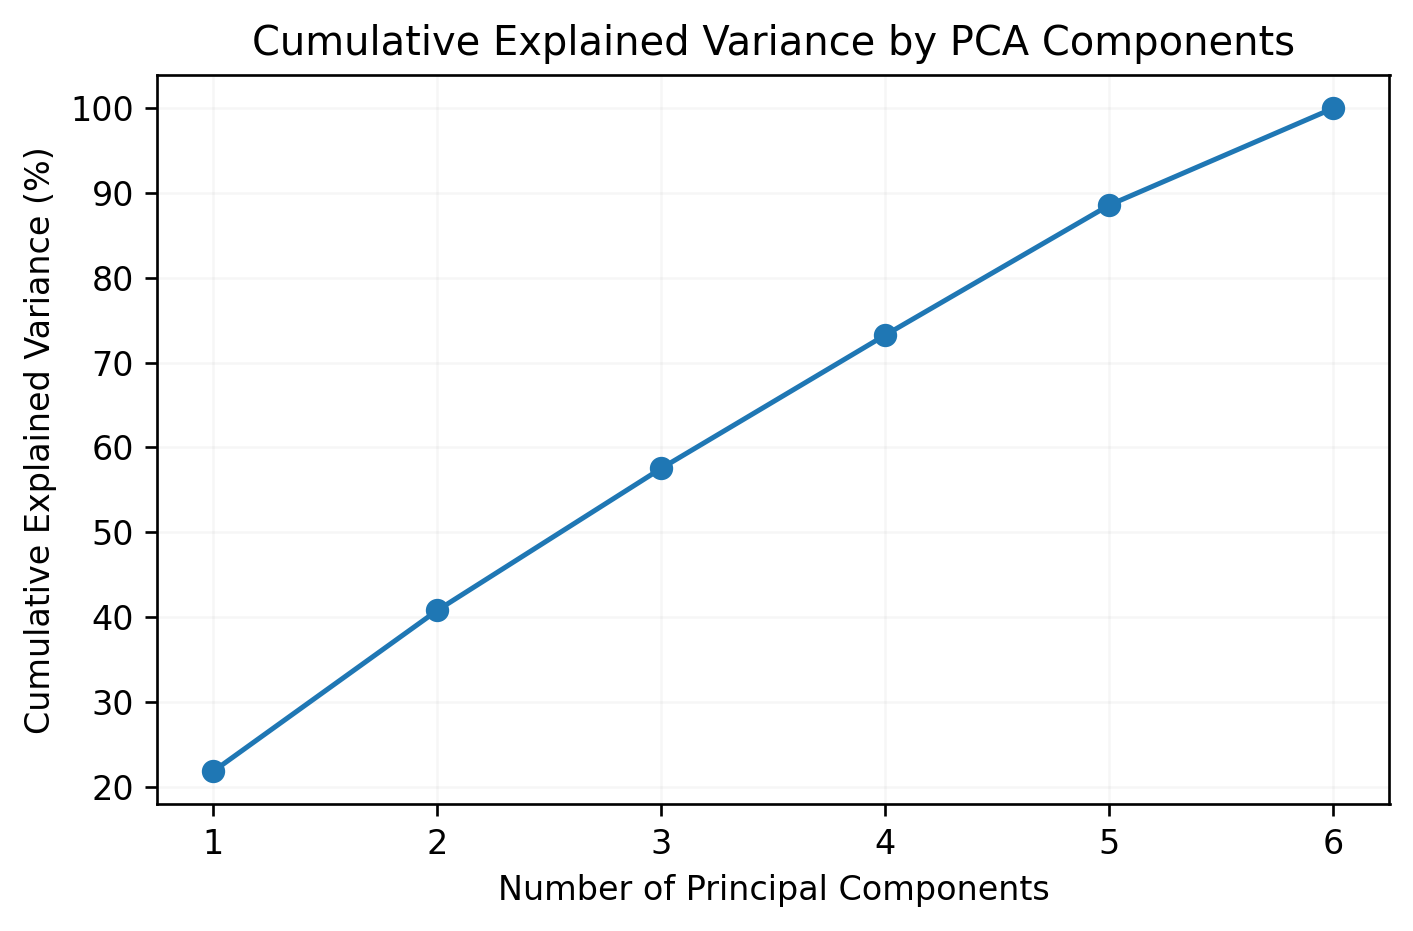

In [12]:
### data v1 ###
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(explained_var_v1)+1), explained_var_v1*100, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

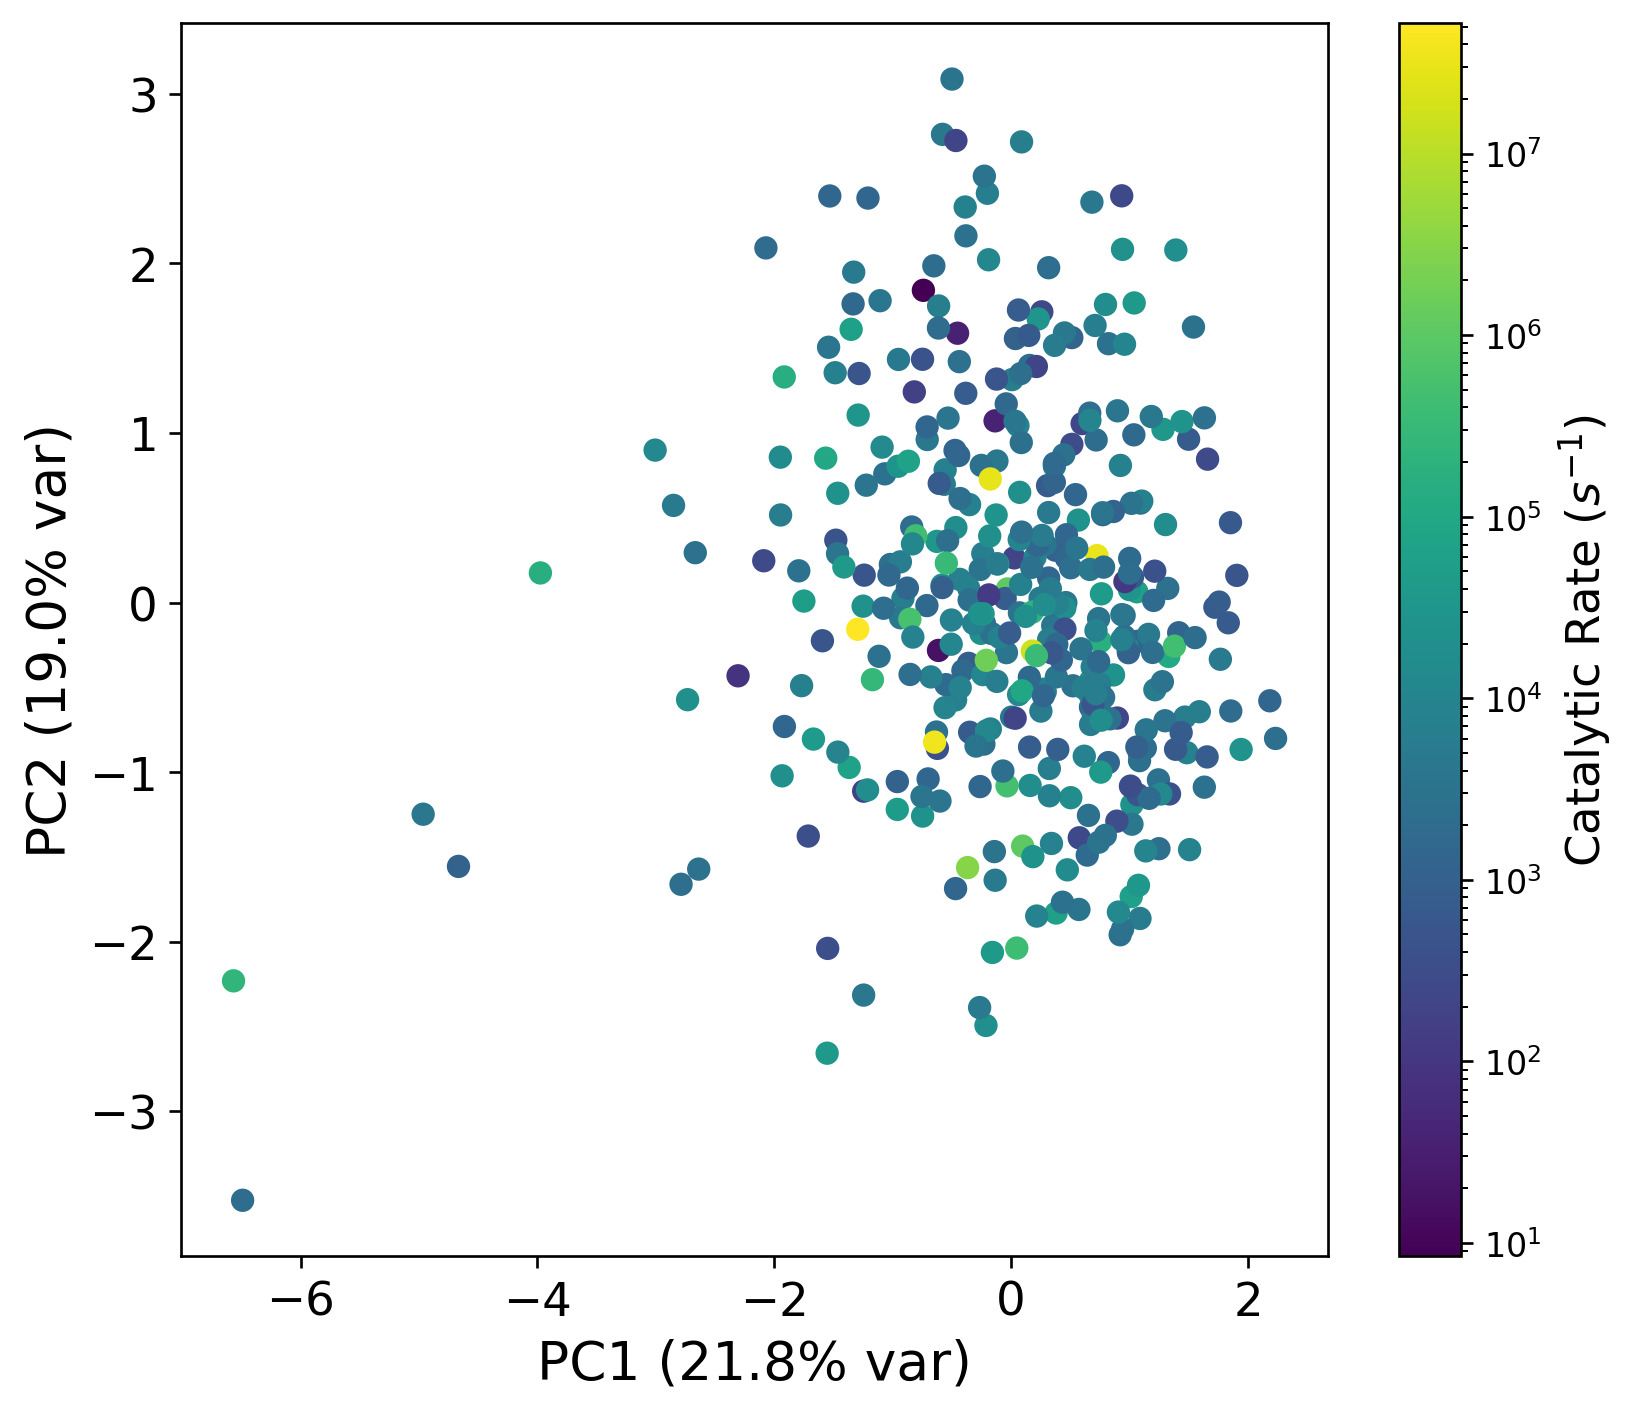

In [13]:
### data v1 ###
pc1_var_v1 = pca.explained_variance_ratio_[0]*100
pc2_var_v1 = pca.explained_variance_ratio_[1]*100

plt.figure(figsize=(7, 6))
plt.scatter(X_pca_v1[:, 0], X_pca_v1[:, 1], c = y_v1,
            norm = LogNorm(), alpha = 1)
cbar = plt.colorbar()
cbar.set_label(label = r"Catalytic Rate ($s^{-1}$)", size=14)
plt.xlabel(f'PC1 ({pc1_var_v1:.1f}% var)', fontsize=16)
plt.ylabel(f'PC2 ({pc2_var_v1:.1f}% var)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('PCA Projection of Site-Structure Features (Version 1)')
plt.tight_layout()
plt.show()

#### data v2

In [14]:
### data v2 ###
pca = PCA()
X_pca_v2 = pca.fit_transform(X_scaled_v2)
explained_var_v2 = np.cumsum(pca.explained_variance_ratio_)

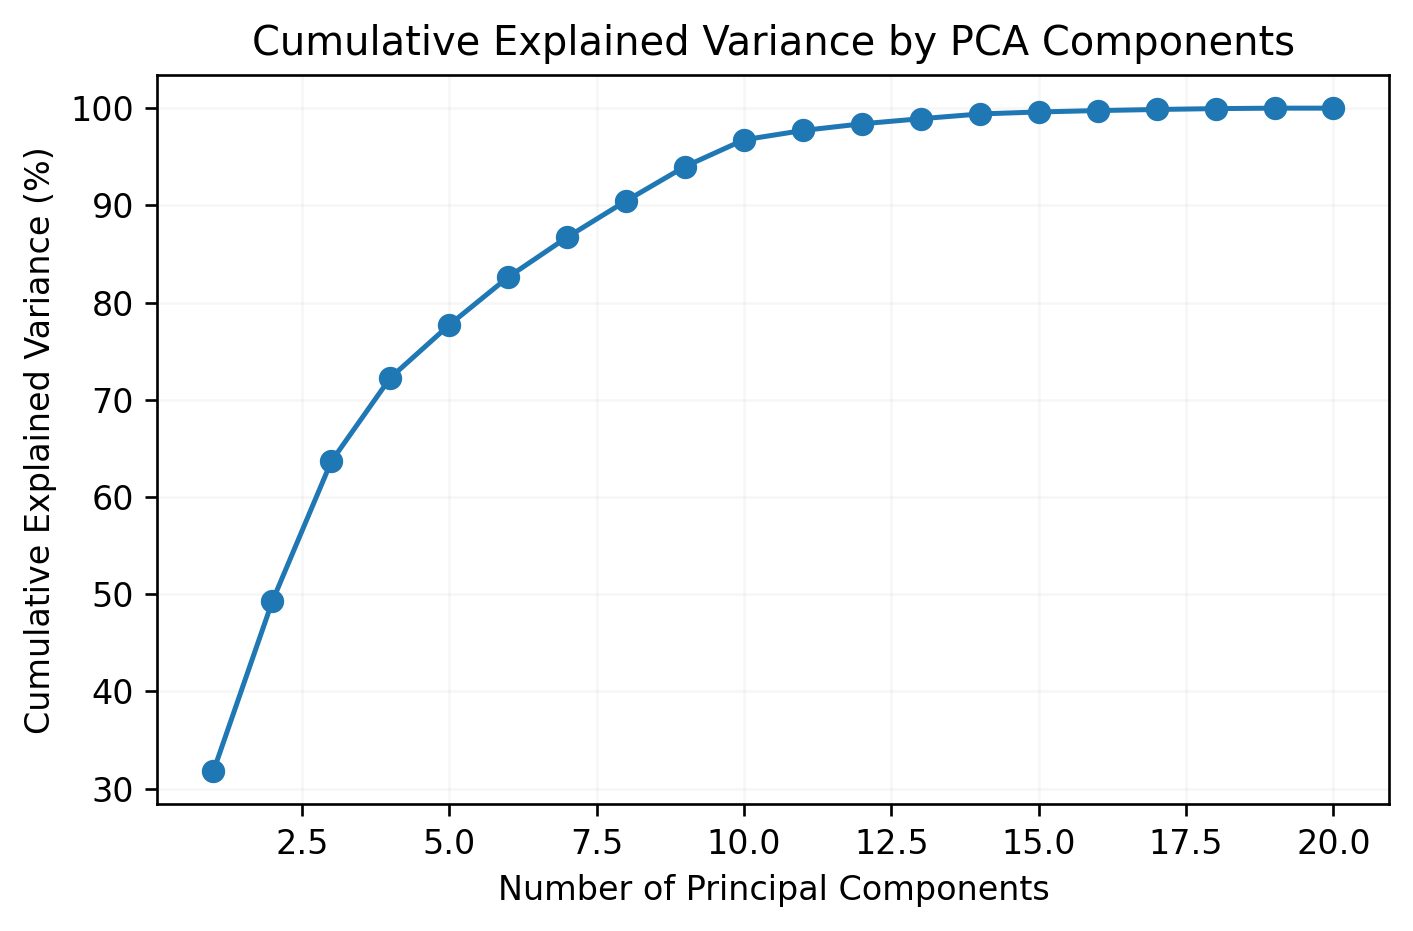

In [15]:
### data v2 ###
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(explained_var_v2)+1), explained_var_v2*100, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

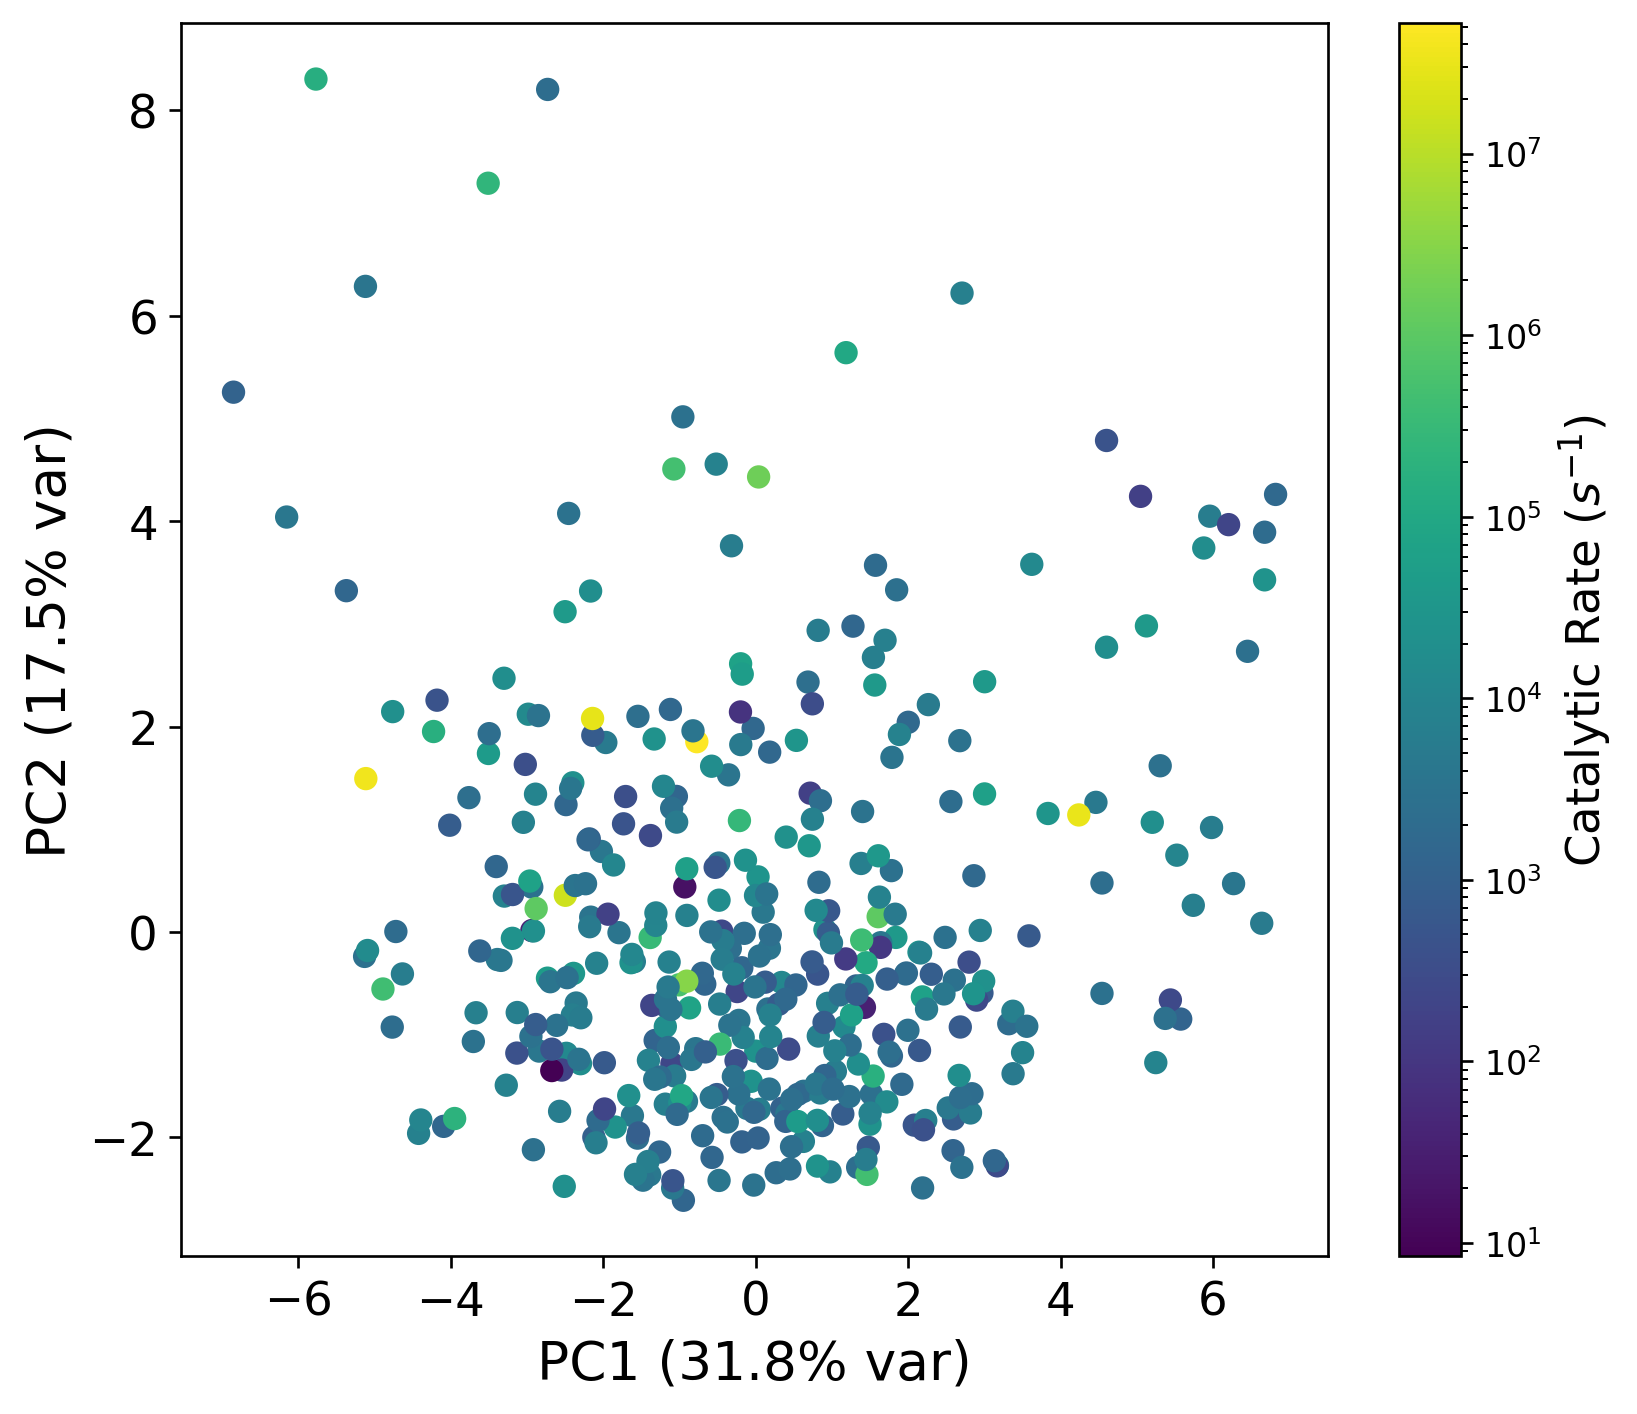

In [16]:
### data v2 ###
pc1_var_v2 = pca.explained_variance_ratio_[0]*100
pc2_var_v2 = pca.explained_variance_ratio_[1]*100

plt.figure(figsize=(7, 6))
plt.scatter(X_pca_v2[:, 0], X_pca_v2[:, 1], c = y_v2,
            norm = LogNorm(), alpha = 1)
cbar = plt.colorbar()
cbar.set_label(label = r"Catalytic Rate ($s^{-1}$)", size=14)
plt.xlabel(f'PC1 ({pc1_var_v2:.1f}% var)', fontsize=16)
plt.ylabel(f'PC2 ({pc2_var_v2:.1f}% var)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('PCA Projection of Site-Structure Features (Version 2)')
plt.tight_layout()
plt.show()

### Kernel PCA

#### data v1

In [17]:
### data v1 ###
n_components = len(features_list_v1)

kernelpca = KernelPCA(
    n_components = n_components,
    kernel = 'rbf',
    gamma = 1/X_scaled_v1.shape[1],
    fit_inverse_transform = False,
    eigen_solver = 'auto',
    remove_zero_eig = True)

X_kernelpca_v1 = kernelpca.fit_transform(X_scaled_v1)

In [18]:
### data v1 ###
lambdas_v1 = kernelpca.eigenvalues_
lambda_frac_v1 = lambdas_v1/np.sum(lambdas_v1)
lambda_cum_v1 = np.cumsum(lambda_frac_v1)

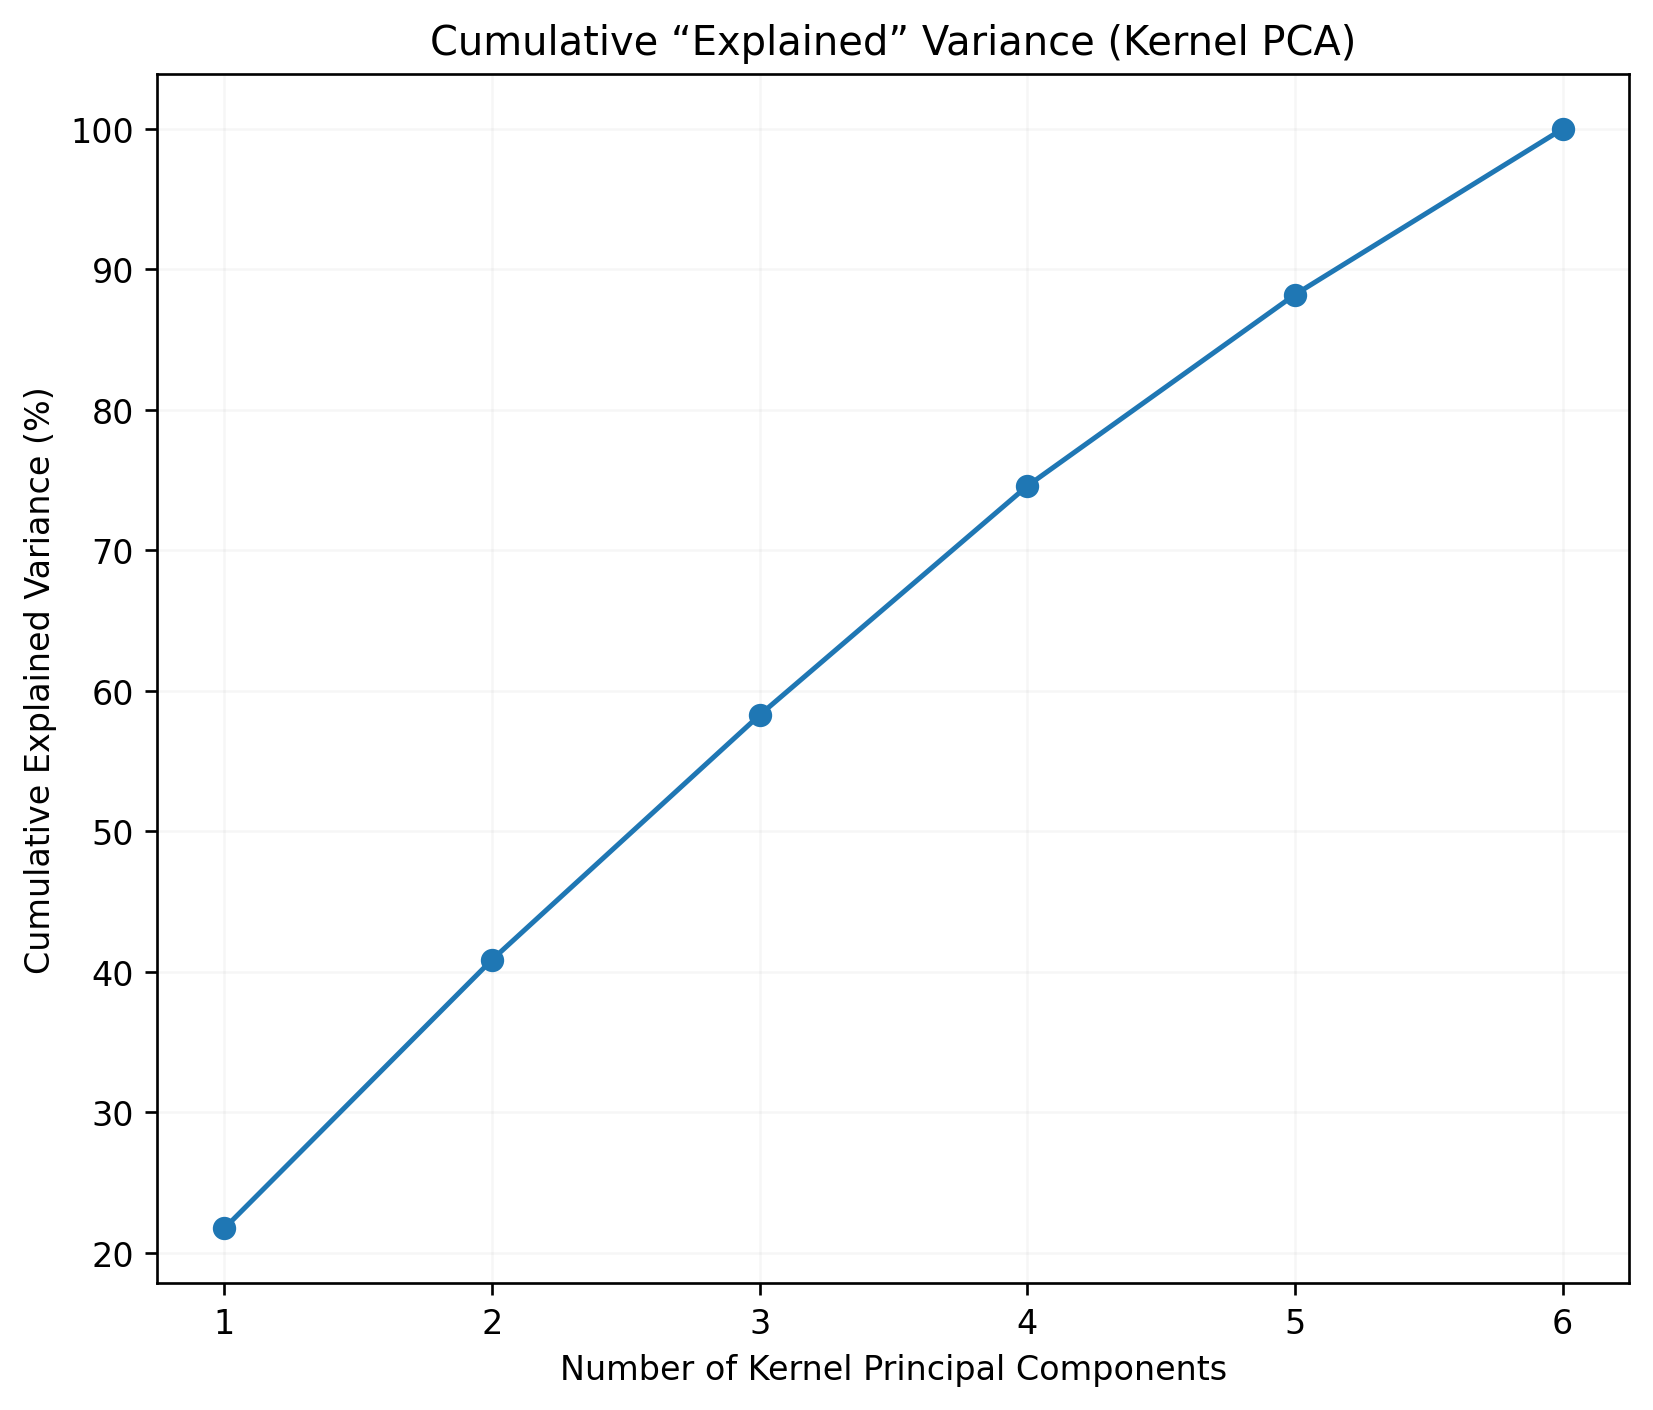

In [19]:
### data v1 ###
plt.figure(figsize=(7, 6))
plt.plot(np.arange(1, len(lambda_cum_v1)+1), lambda_cum_v1*100, marker='o')
plt.xlabel('Number of Kernel Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative “Explained” Variance (Kernel PCA)')
plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

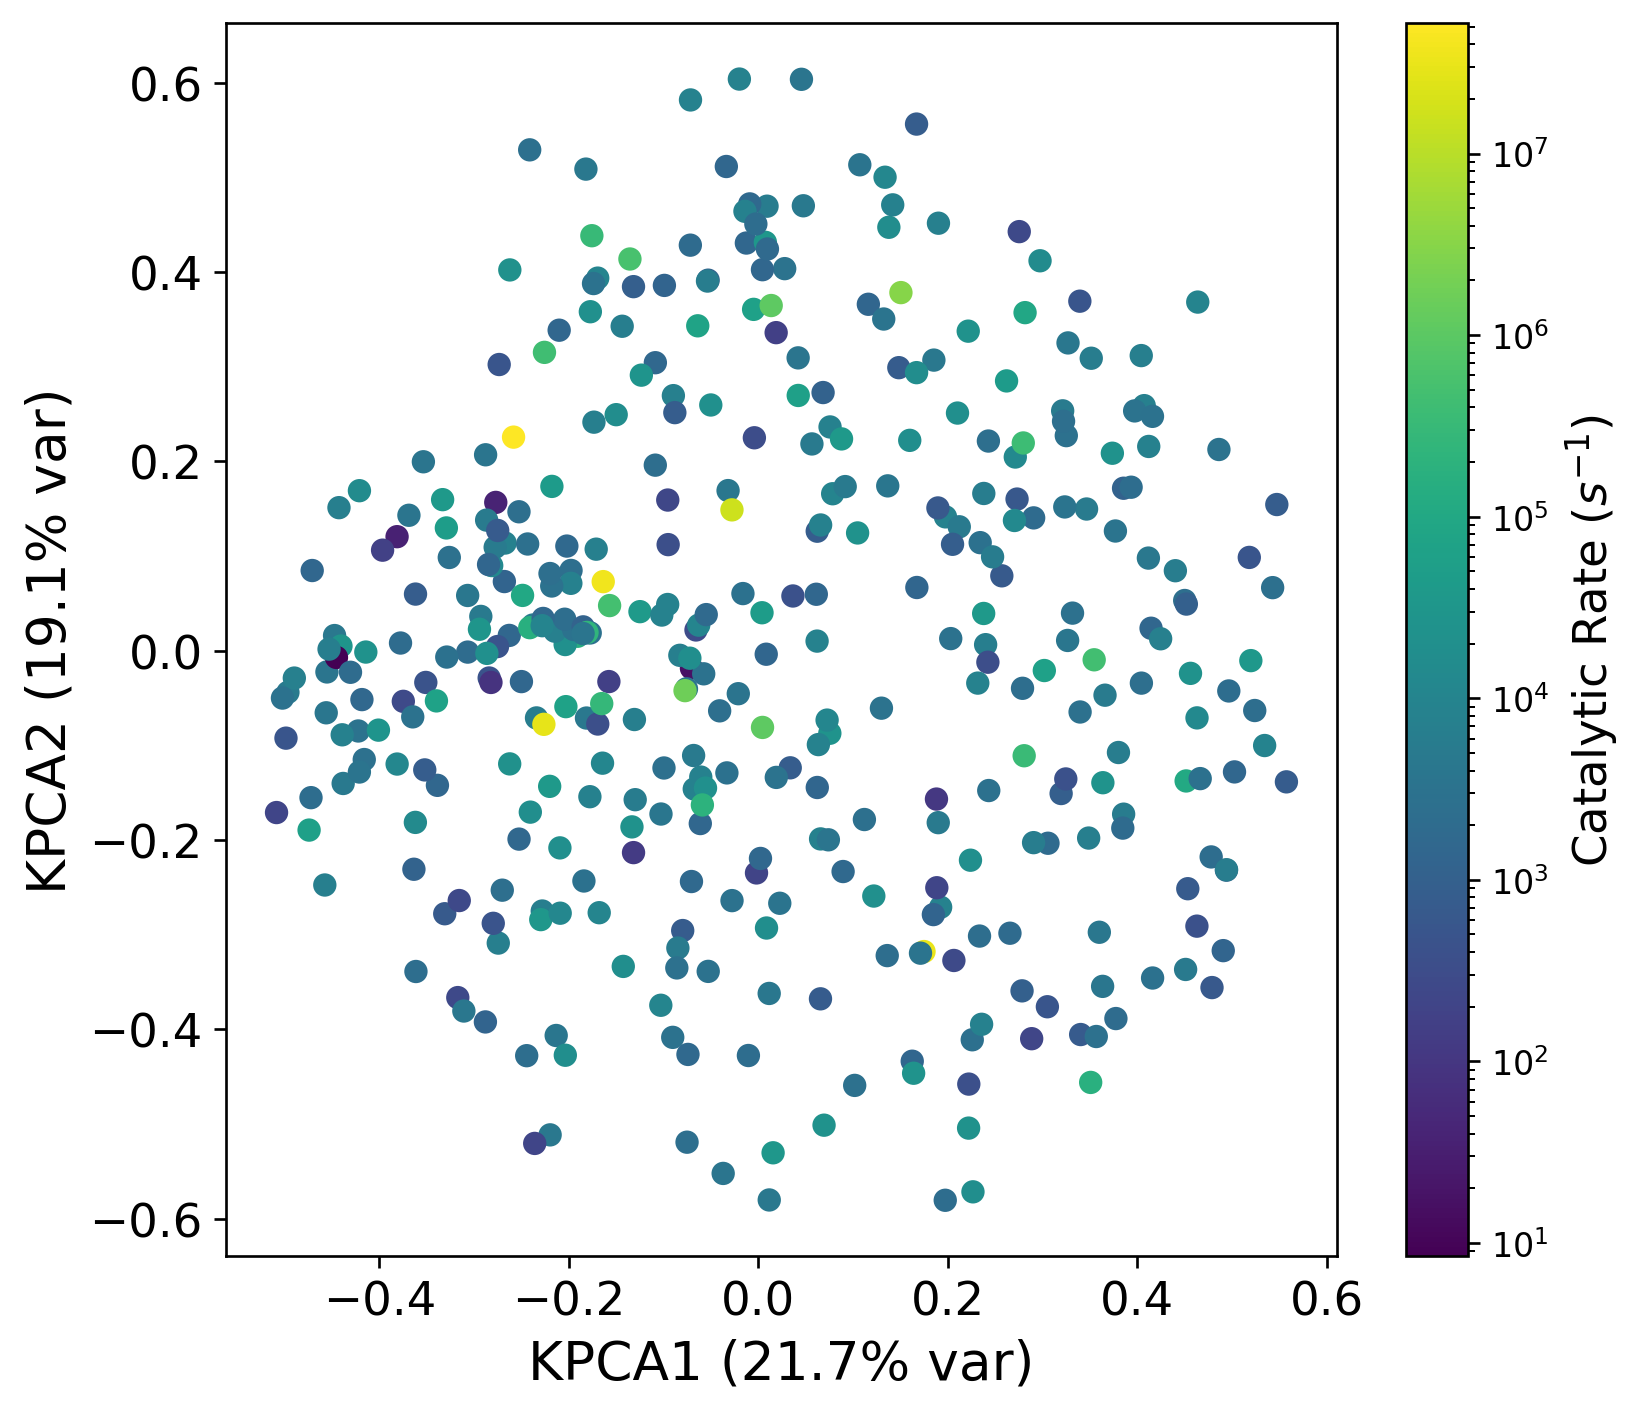

In [20]:
### data v1 ###
kpc1_var_v1 = lambda_frac_v1[0]*100
kpc2_var_v2 = lambda_frac_v1[1]*100

plt.figure(figsize=(7, 6))
plt.scatter(X_kernelpca_v1[:, 0], X_kernelpca_v1[:, 1], c = y_v1,
            norm = LogNorm(), alpha = 1)
#plt.title('Kernel PCA Projection of Site-Structure Features (Version 1)')
cbar = plt.colorbar()
cbar.set_label(label = r"Catalytic Rate ($s^{-1}$)", size=14)
plt.xlabel(f'KPCA1 ({kpc1_var_v1:.1f}% var)', fontsize=16)
plt.ylabel(f'KPCA2 ({kpc2_var_v2:.1f}% var)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

#### data v2

In [21]:
### data v2 ###
n_components = len(features_list_v2)

kernelpca = KernelPCA(
    n_components = n_components,
    kernel = 'rbf',
    gamma = 1/X_scaled_v1.shape[1],
    fit_inverse_transform = False,
    eigen_solver = 'auto',
    remove_zero_eig = True)

X_kernelpca_v2 = kernelpca.fit_transform(X_scaled_v2)

In [22]:
### data v2 ###
lambdas_v2 = kernelpca.eigenvalues_
lambda_frac_v2 = lambdas_v2/np.sum(lambdas_v2)
lambda_cum_v2 = np.cumsum(lambda_frac_v2)

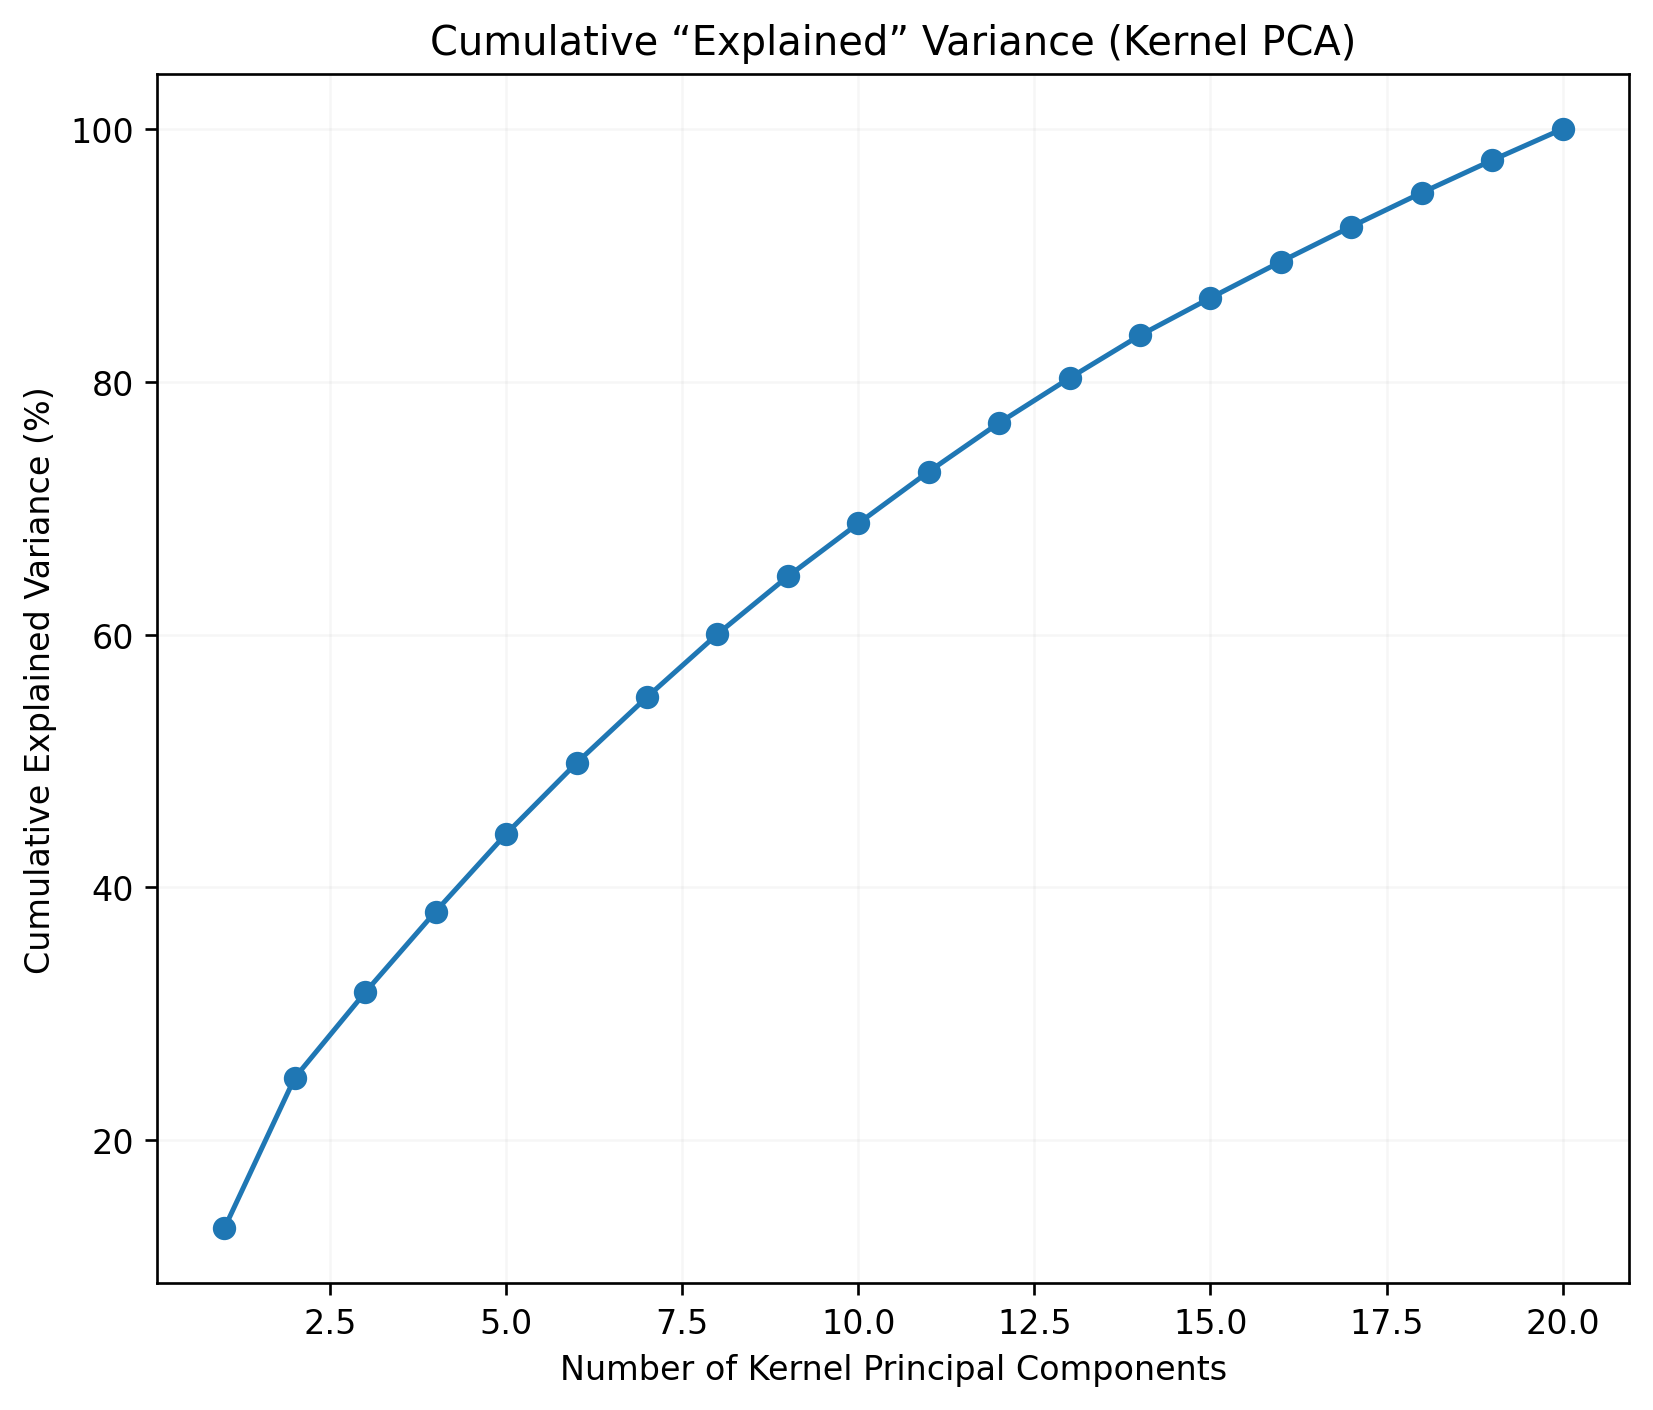

In [23]:
### data v2 ###
plt.figure(figsize=(7, 6))
plt.plot(np.arange(1, len(lambda_cum_v2)+1), lambda_cum_v2*100, marker='o')
plt.xlabel('Number of Kernel Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative “Explained” Variance (Kernel PCA)')
plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

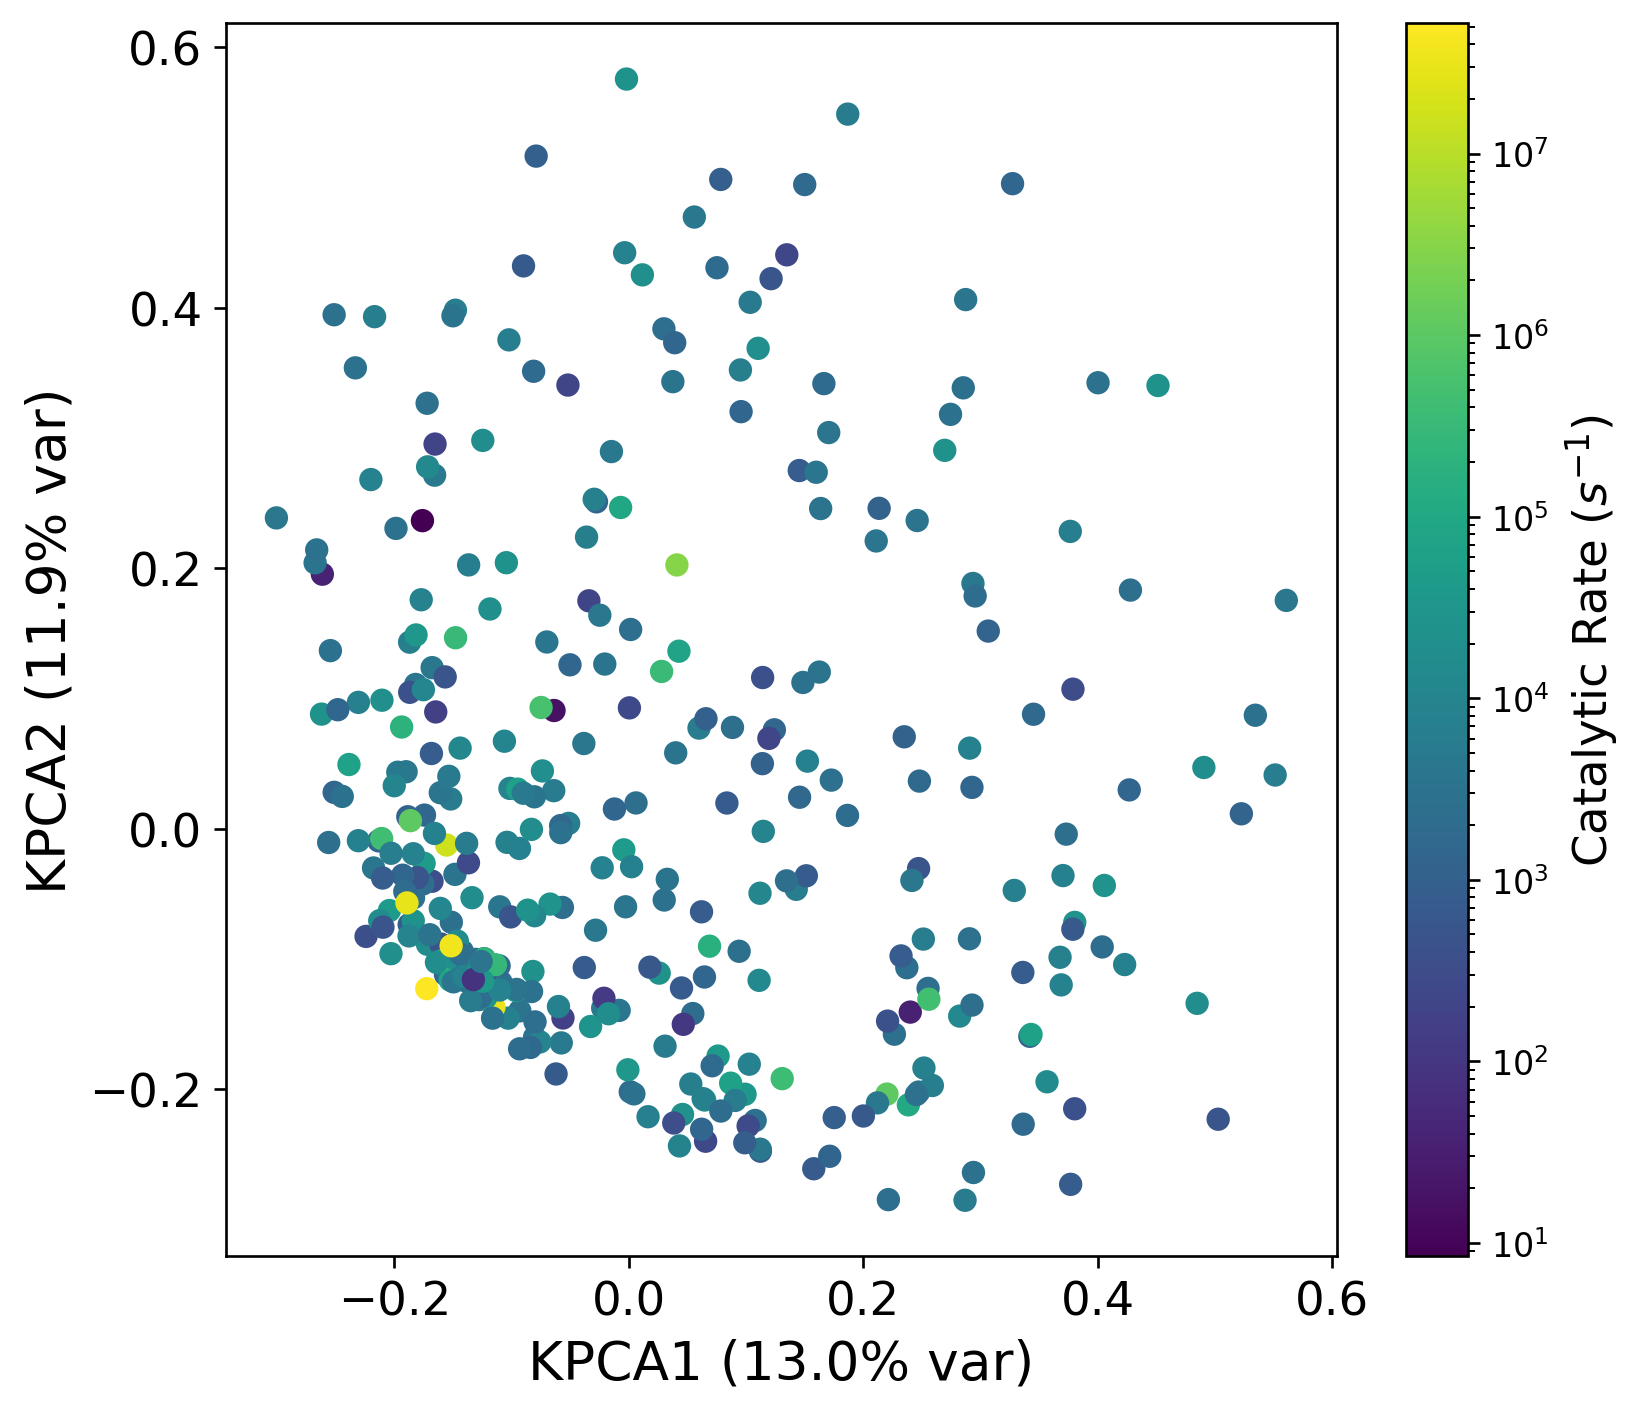

In [24]:
### data v2 ###
kpc1_var_v2 = lambda_frac_v2[0]*100
kpc2_var_v2 = lambda_frac_v2[1]*100

plt.figure(figsize=(7, 6))
plt.scatter(X_kernelpca_v2[:, 0], X_kernelpca_v2[:, 1], c = y_v2,
            norm = LogNorm(), alpha = 1)
cbar = plt.colorbar()
cbar.set_label(label = r"Catalytic Rate ($s^{-1}$)", size=14)
plt.xlabel(f'KPCA1 ({kpc1_var_v2:.1f}% var)', fontsize=16)
plt.ylabel(f'KPCA2 ({kpc2_var_v2:.1f}% var)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Kernel PCA Projection of Site-Structure Features (Version 2)')
plt.tight_layout()
plt.show()

### tSNE

#### data v1

In [25]:
### data v1 ###
t_sne = TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=10,
    max_iter=250,
    init="random",
    random_state = 0
)

X_tsne250_v1 = t_sne.fit_transform(X_scaled_v1)

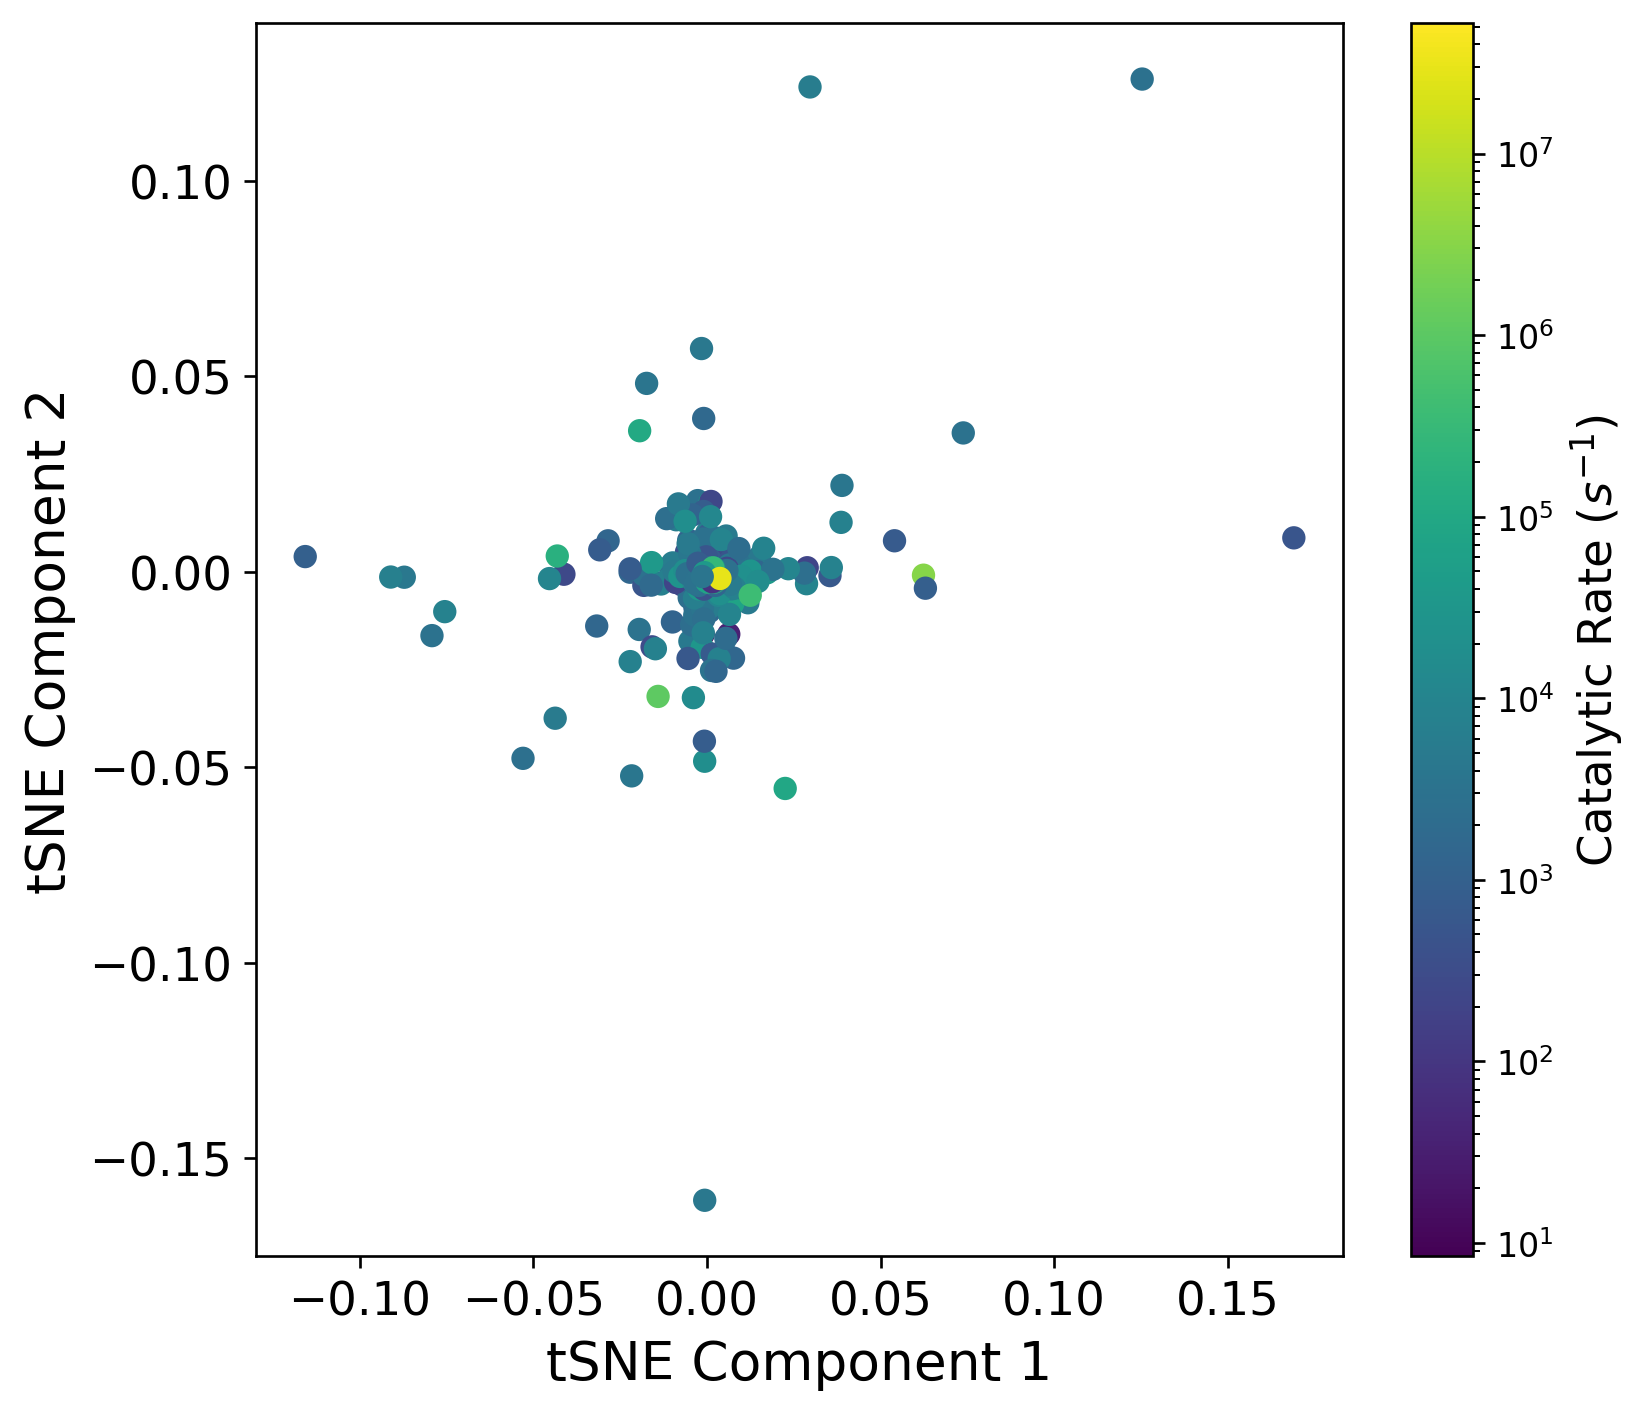

In [26]:
### data v1 ###
plt.figure(figsize=(7, 6))
plt.scatter(X_tsne250_v1[:, 0], X_tsne250_v1[:, 1], c = y_v1,
            norm = LogNorm(), alpha = 1)
#plt.title("tSNE Projection of Site-Structure Features (Version 1)")
cbar = plt.colorbar()
cbar.set_label(label = r"Catalytic Rate ($s^{-1}$)", size=14)
plt.xlabel("tSNE Component 1", fontsize=16)
plt.ylabel("tSNE Component 2", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

#### data v2

In [27]:
### data v2 ###
t_sne = TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=10,
    max_iter=250,
    init="random",
    random_state = 0
)

X_tsne250_v2 = t_sne.fit_transform(X_scaled_v2)

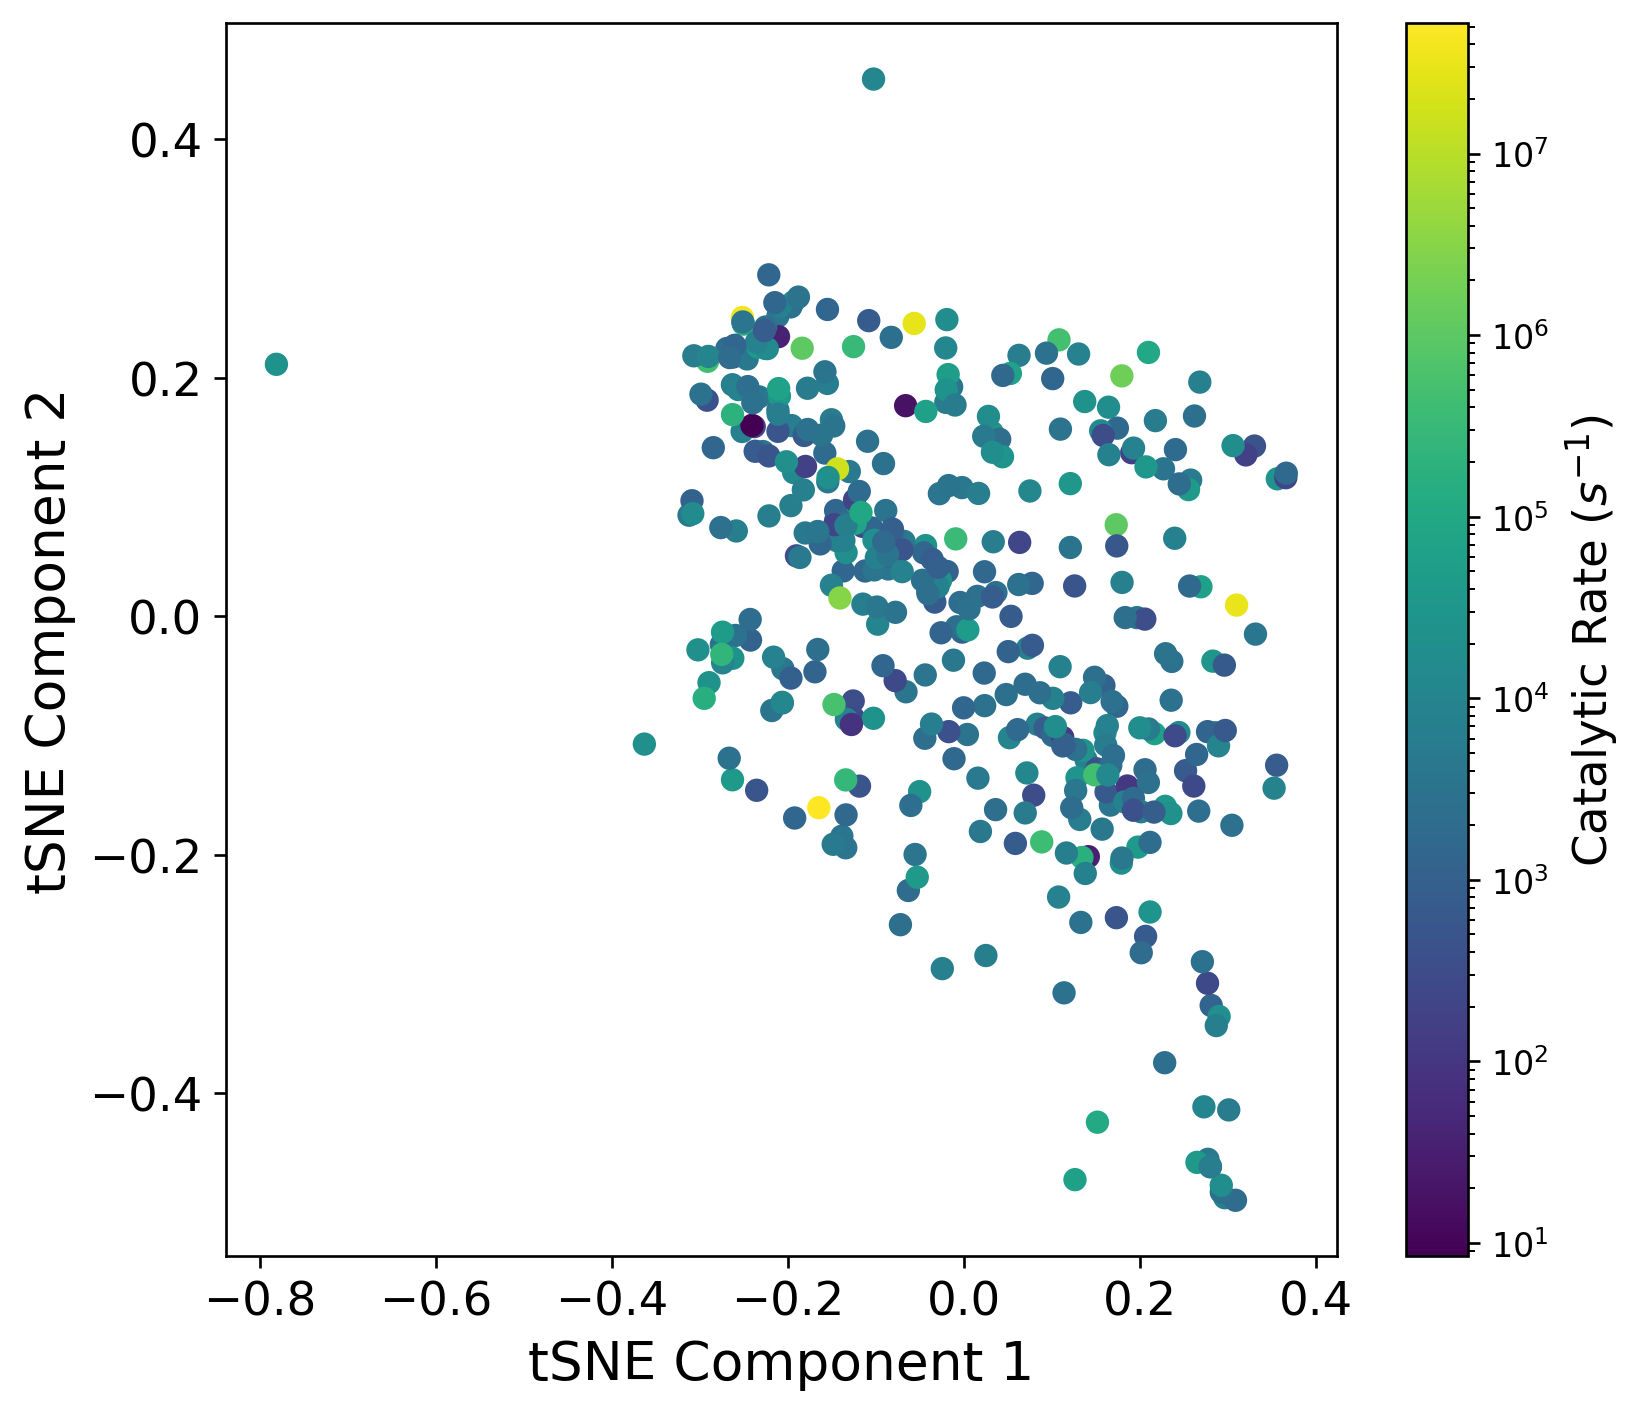

In [39]:
### data v2 ###
plt.figure(figsize=(7, 6))
plt.scatter(X_tsne250_v2[:, 0], X_tsne250_v2[:, 1], c = y_v2,
            norm = LogNorm(), alpha = 1)
cbar = plt.colorbar()
cbar.set_label(label = r"Catalytic Rate ($s^{-1}$)", size=14)
plt.xlabel("tSNE Component 1", fontsize=16)
plt.ylabel("tSNE Component 2", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

### UMAP

#### data v1

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


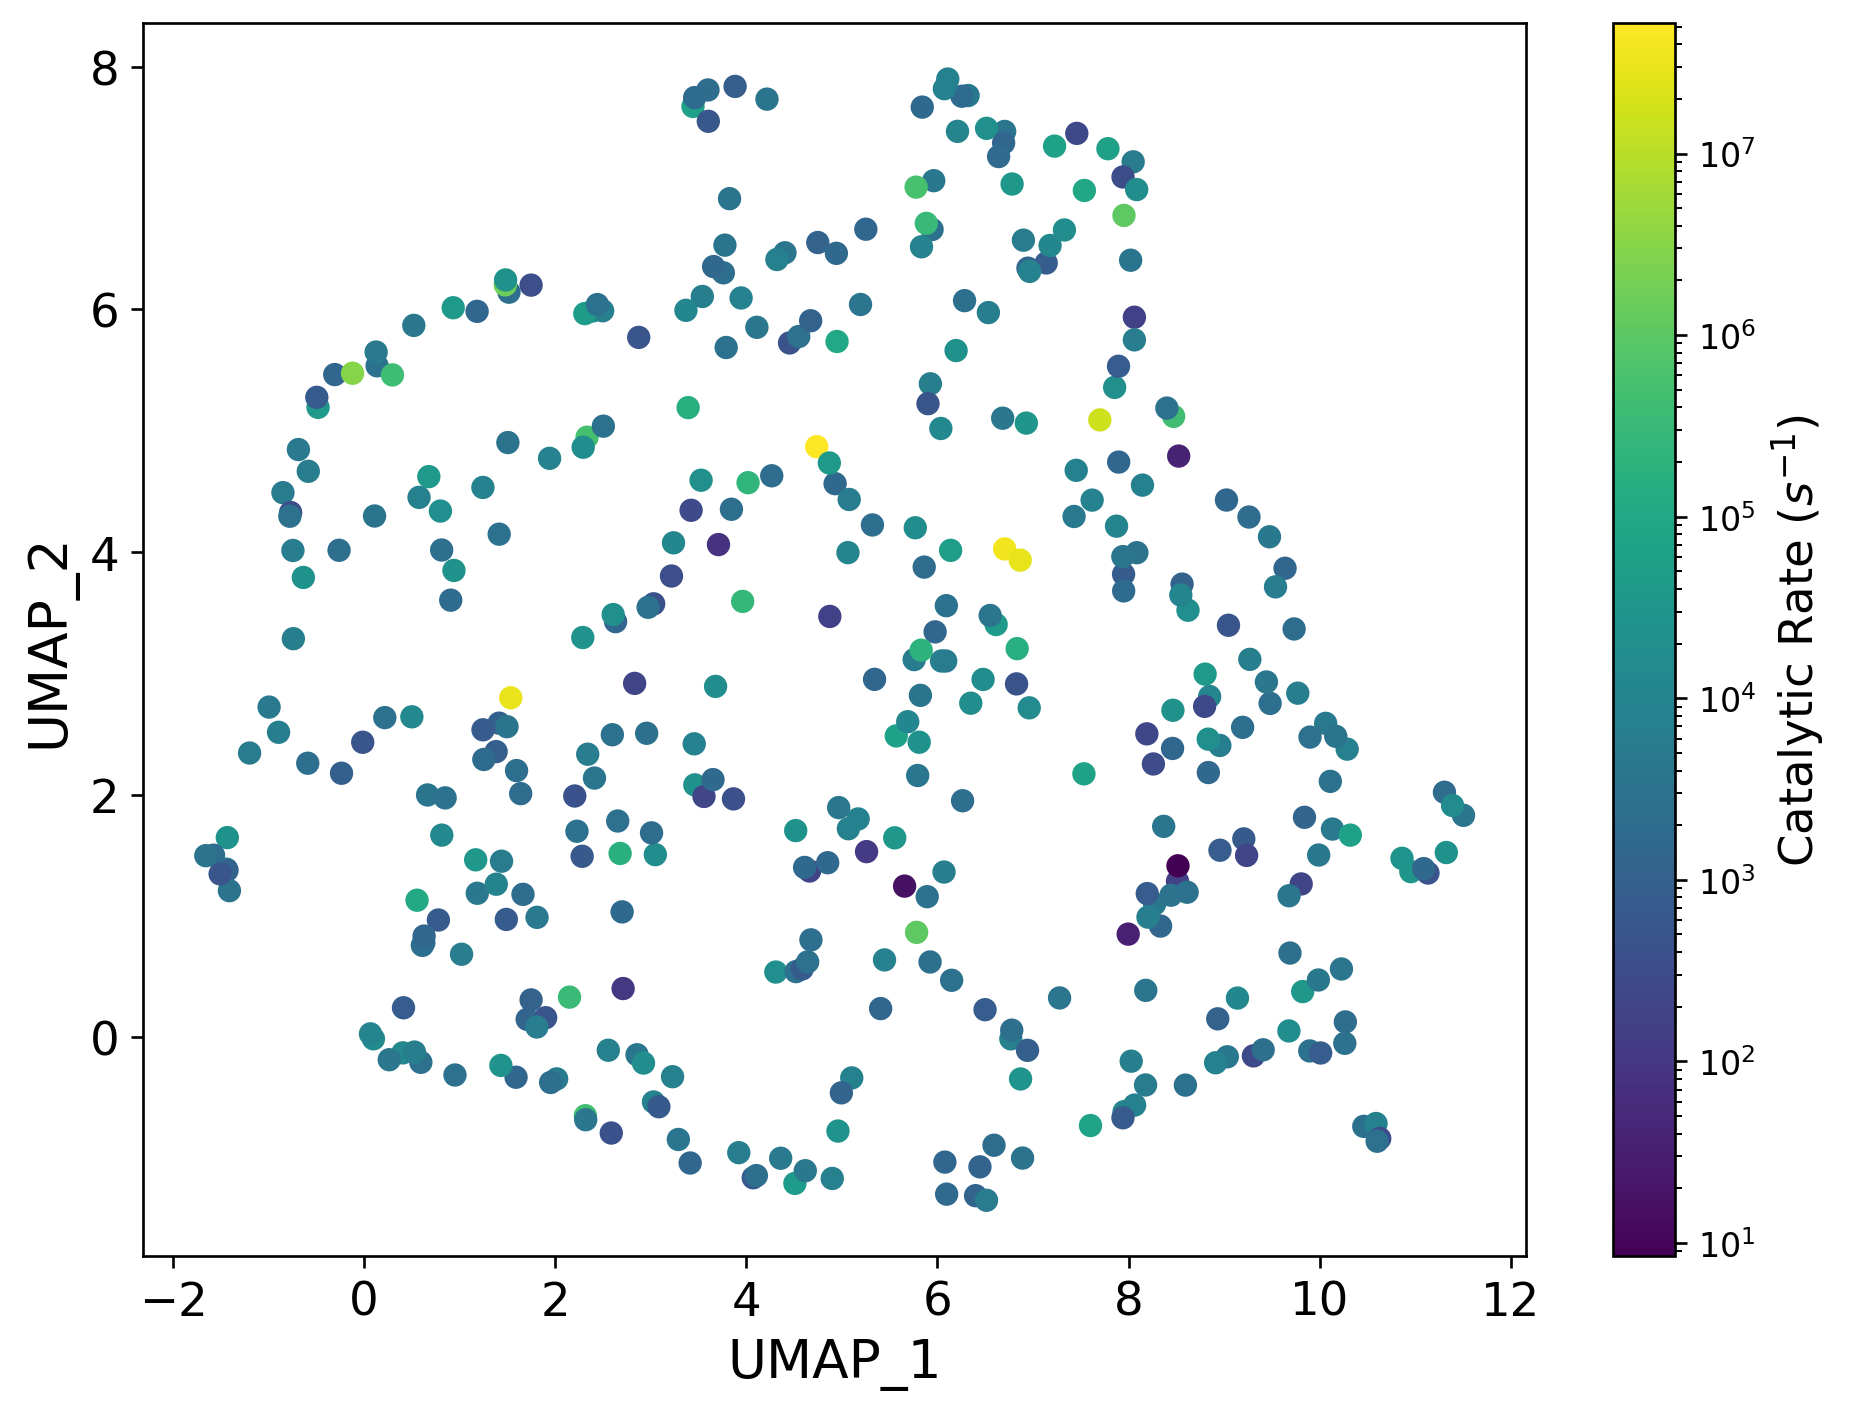

In [29]:
### data v1 ###
reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.3,
    metric='correlation',
    n_components=2,
    random_state=0
)

# Fit *unsupervised*
reducer.fit(X_scaled_v1)
# Transform to 2D
X_umap_v1 = reducer.transform(X_scaled_v1)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap_v1[:, 0], X_umap_v1[:, 1], c = y_v1,
            norm = LogNorm(), alpha = 1)
cbar = plt.colorbar()
cbar.set_label(label = r"Catalytic Rate ($s^{-1}$)", size=14)
plt.xlabel("UMAP_1", fontsize=16)
plt.ylabel("UMAP_2", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("Unsupervised UMAP Projection of Site-Structure Features (Version 1)")
plt.tight_layout()
plt.show()



#### data v2

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


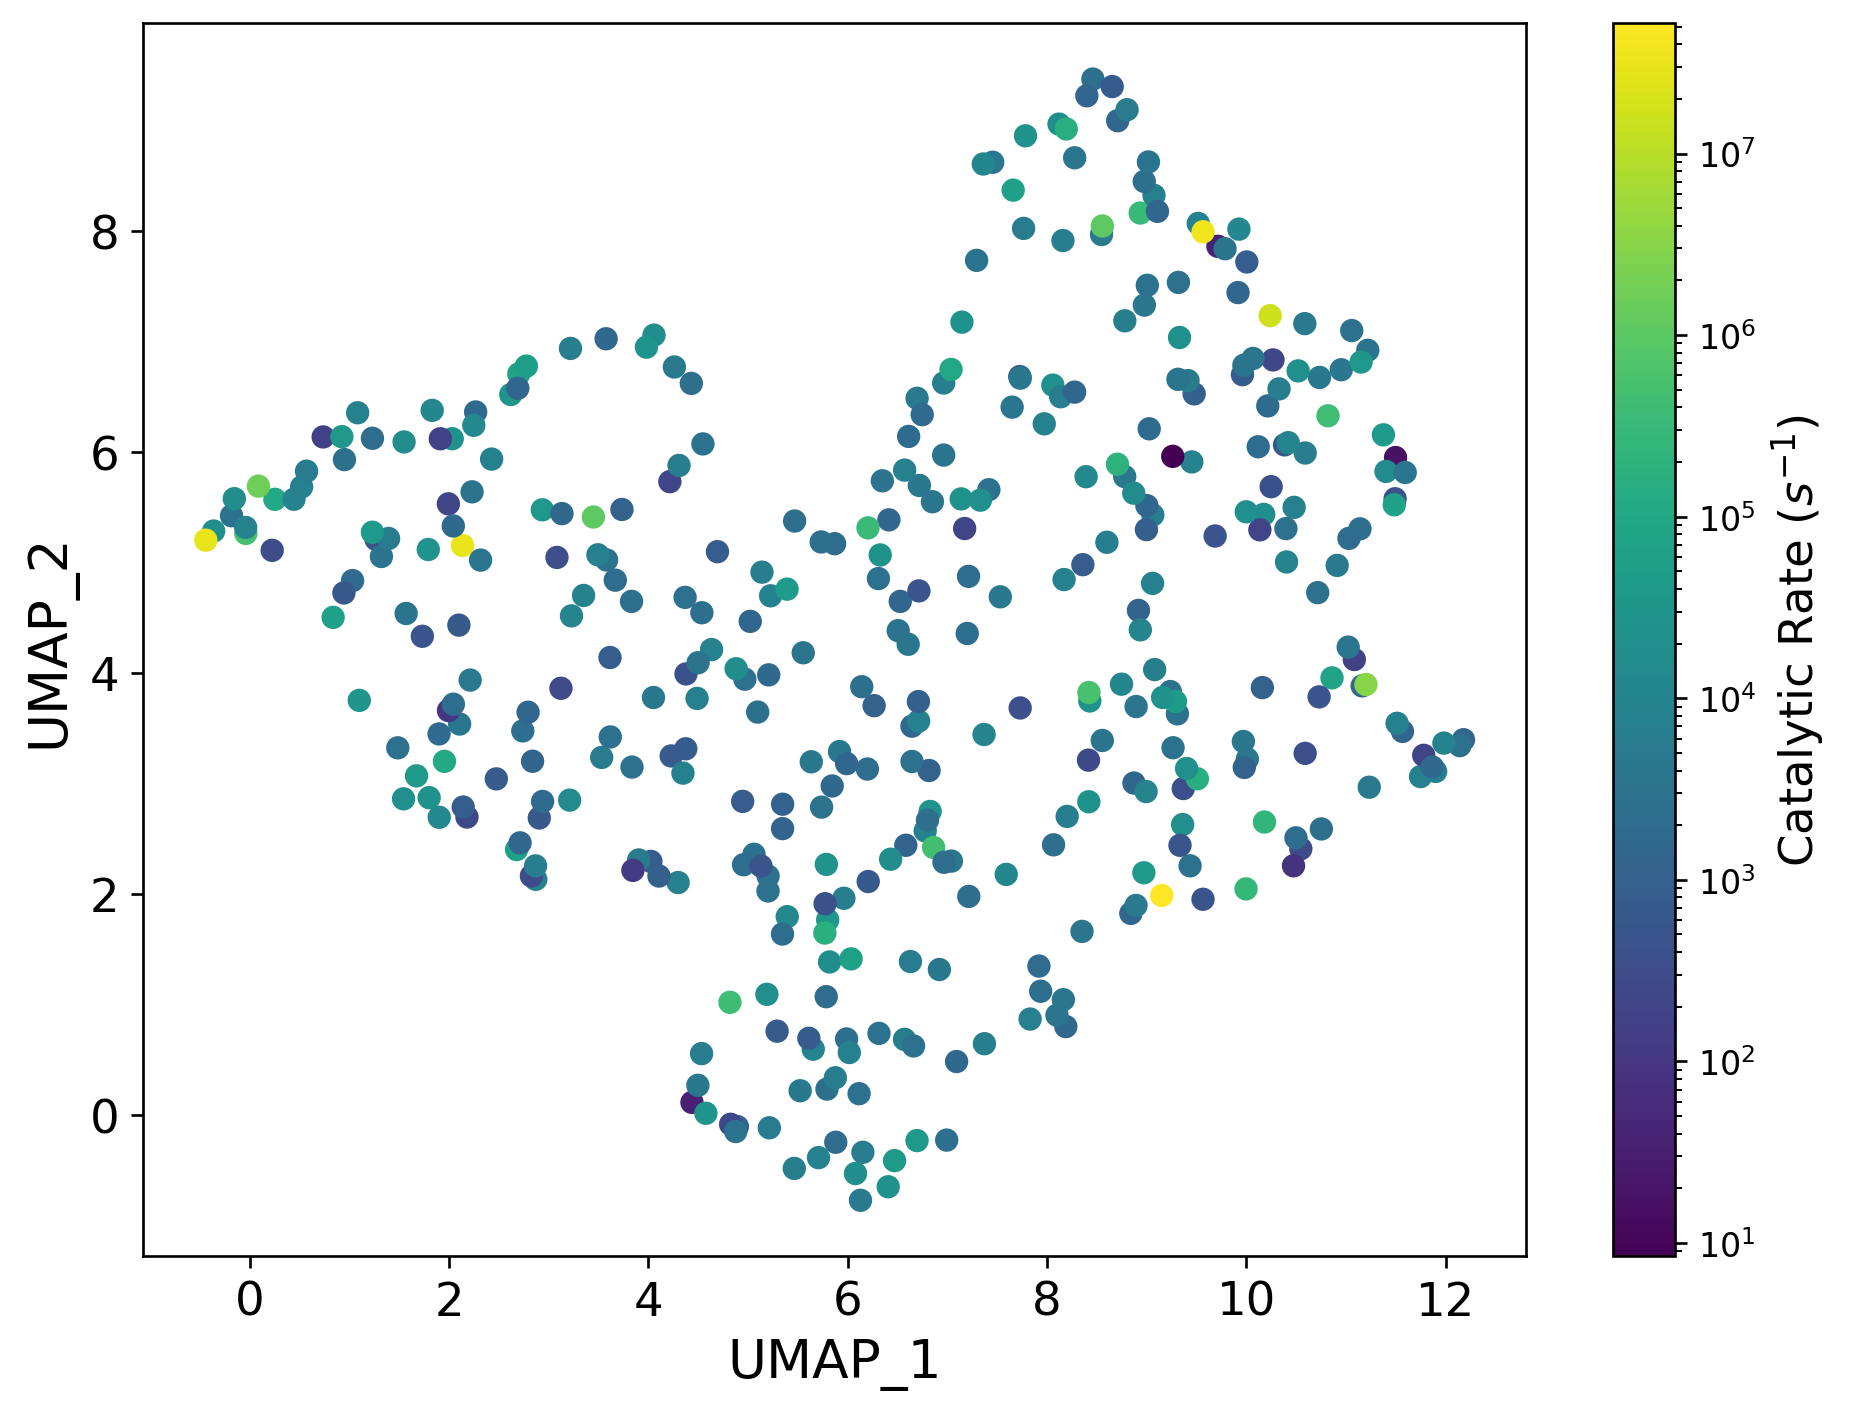

In [30]:
### data v2 ###
reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.3,
    metric='correlation',
    n_components=2,
    random_state=0
)

# Fit *unsupervised*
reducer.fit(X_scaled_v2)
# Transform to 2D
X_umap_v2 = reducer.transform(X_scaled_v2)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap_v2[:, 0], X_umap_v2[:, 1], c = y_v2,
            norm = LogNorm(), alpha = 1)
cbar = plt.colorbar()
cbar.set_label(label = r"Catalytic Rate ($s^{-1}$)", size=14)
plt.xlabel("UMAP_1", fontsize=16)
plt.ylabel("UMAP_2", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("Unsupervised UMAP Projection of Site-Structure Features (Version 2)")
plt.tight_layout()
plt.show()

### Supervised umap

#### data v1

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


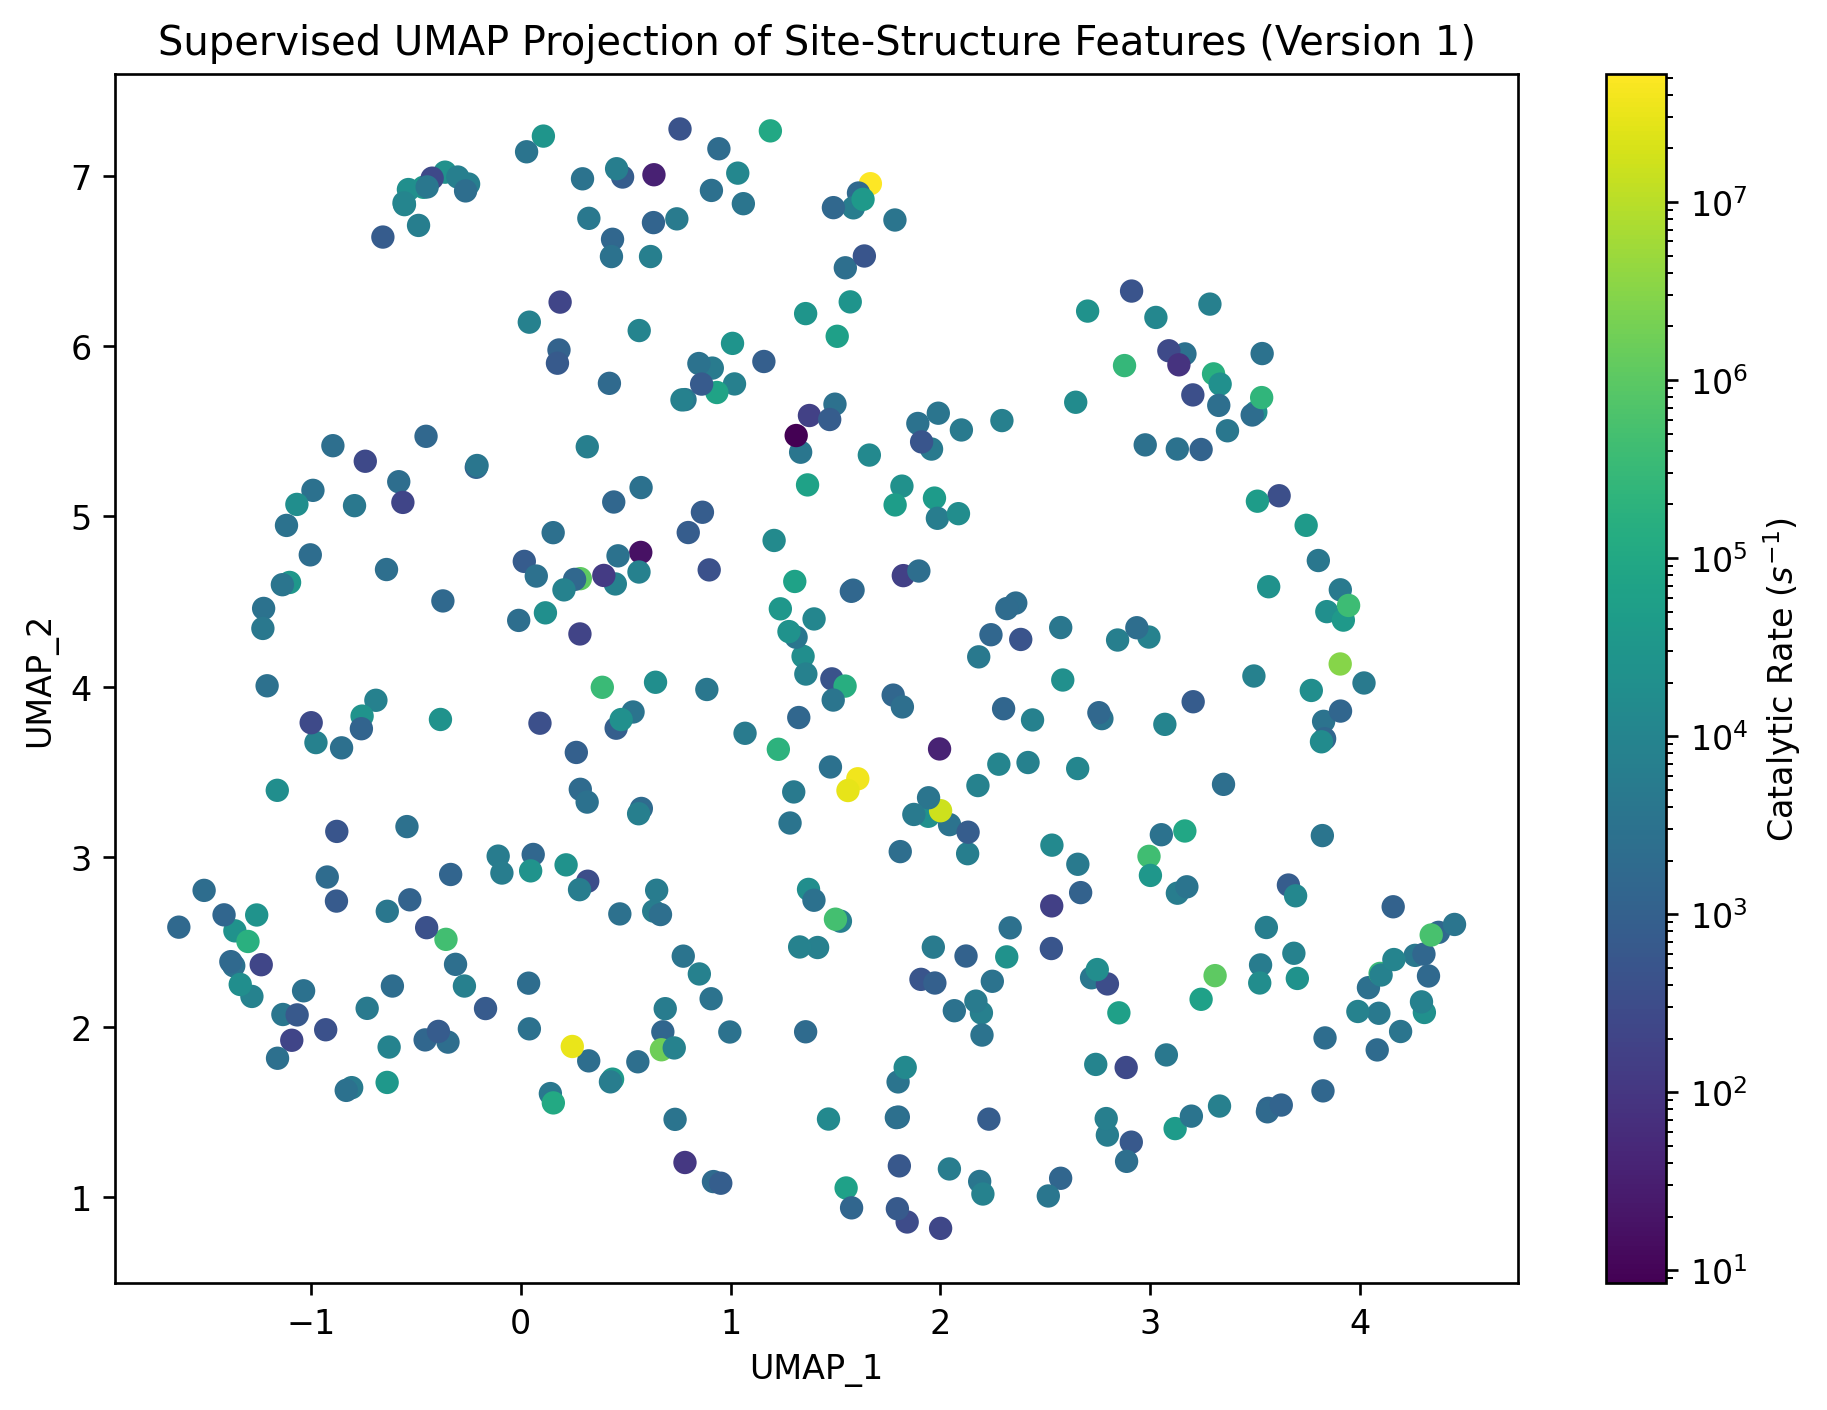

In [31]:
### data v1 ###
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

# Fit with supervision (y)
reducer.fit(X_scaled_v1, y = y_v1)
# Transform to 2D
X_sumap_v1 = reducer.transform(X_scaled_v1)

plt.figure(figsize=(8, 6))
plt.scatter(X_sumap_v1[:, 0], X_sumap_v1[:, 1], c = y_v1,
            norm = LogNorm(), alpha = 1)
plt.colorbar(label = r"Catalytic Rate ($s^{-1}$)")
plt.xlabel(f'UMAP_1')
plt.ylabel(f'UMAP_2')
plt.title('Supervised UMAP Projection of Site-Structure Features (Version 1)')
plt.tight_layout()
plt.show()

#### data v2

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


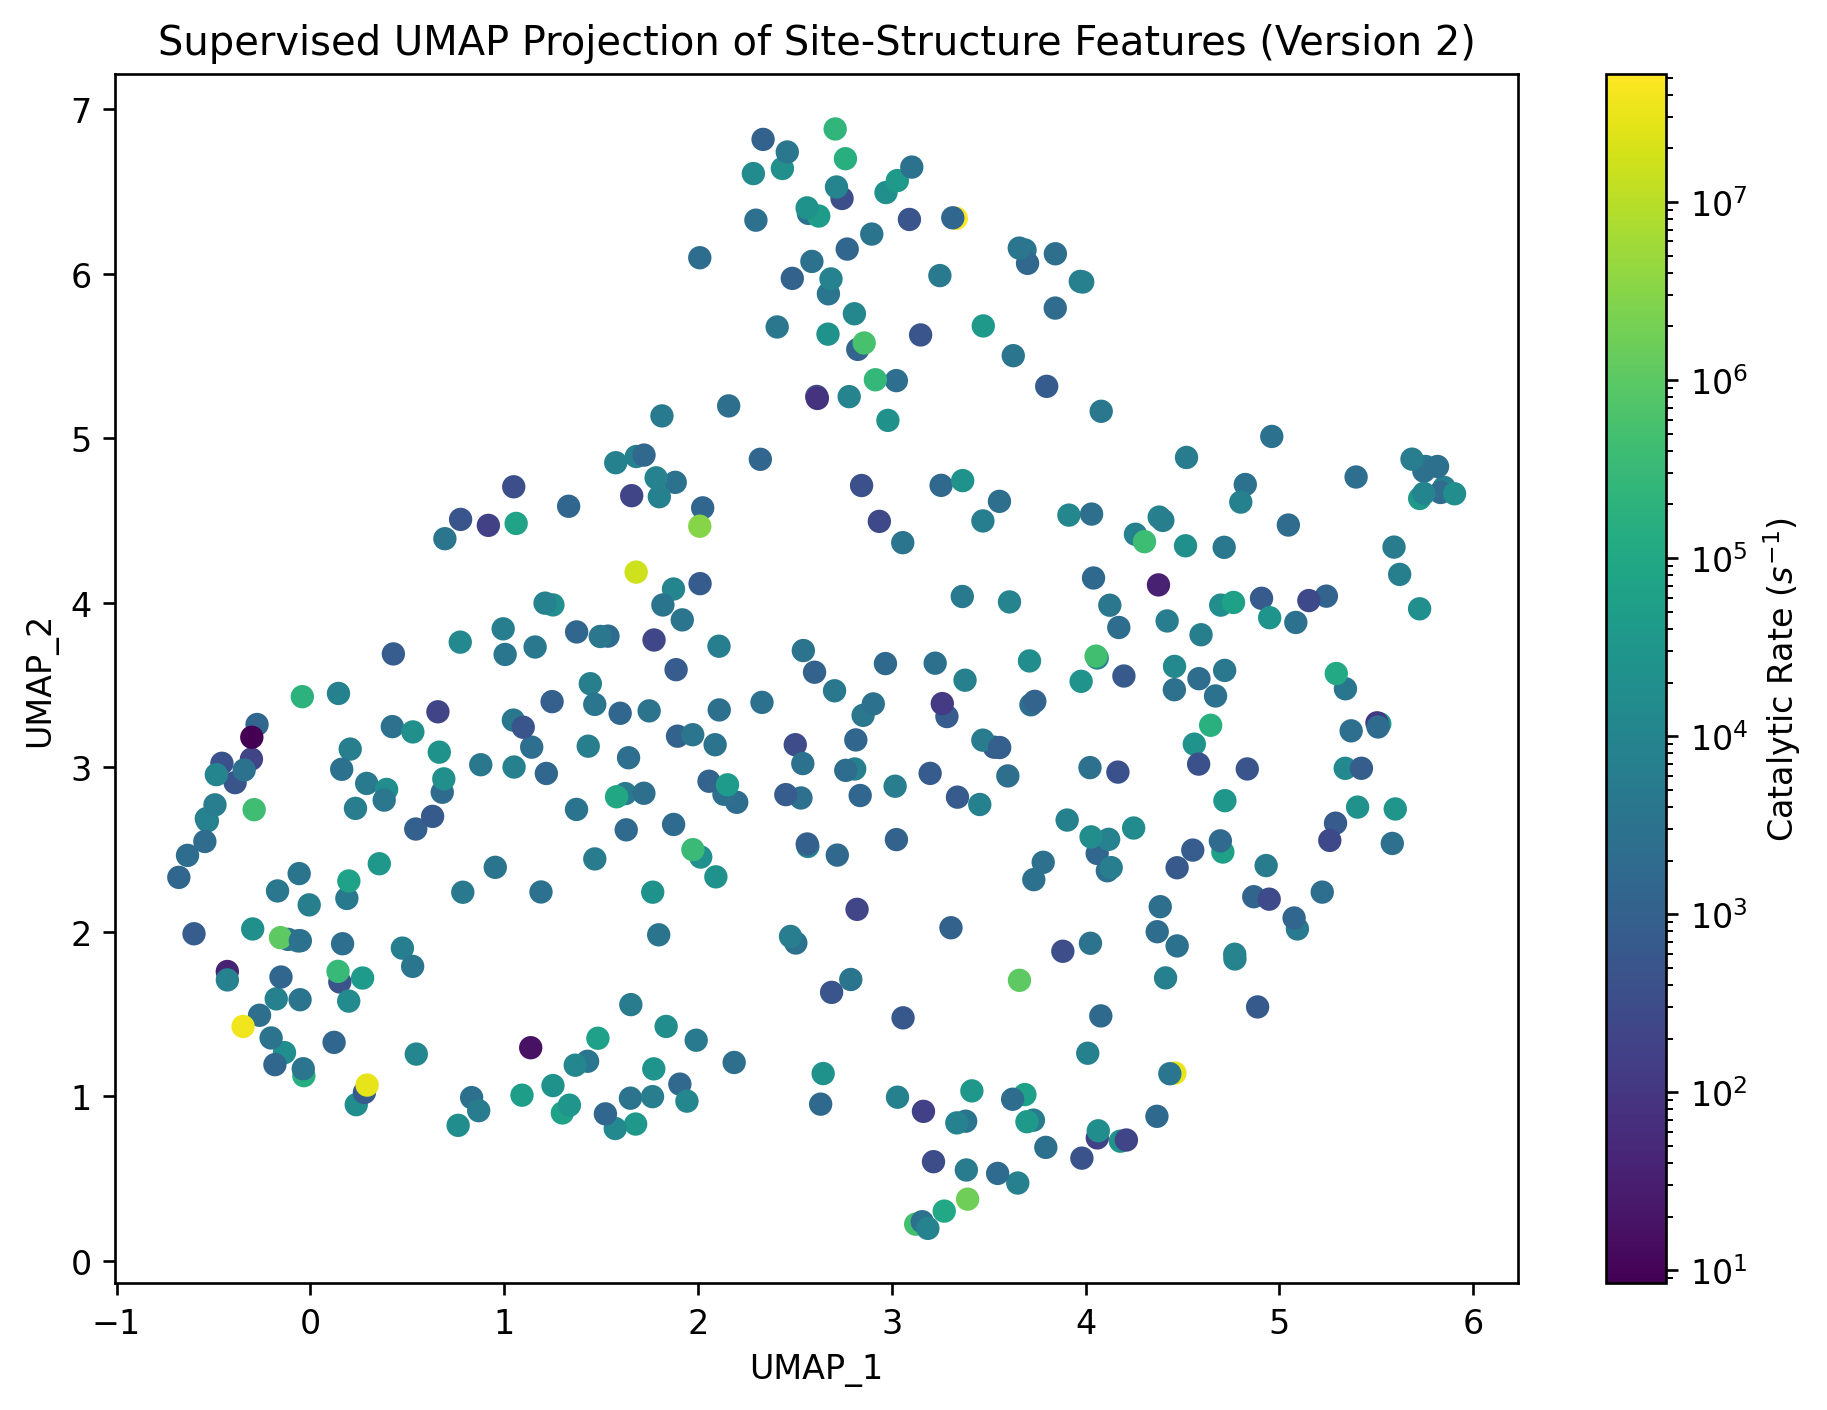

In [32]:
### data v2 ###
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

# Fit with supervision (y)
reducer.fit(X_scaled_v2, y = y_v2)
# Transform to 2D
X_sumap_v2 = reducer.transform(X_scaled_v2)

plt.figure(figsize=(8, 6))
plt.scatter(X_sumap_v2[:, 0], X_sumap_v2[:, 1], c = y_v2,
            norm = LogNorm(), alpha = 1)
plt.colorbar(label = r"Catalytic Rate ($s^{-1}$)")
plt.xlabel(f'UMAP_1')
plt.ylabel(f'UMAP_2')
plt.title('Supervised UMAP Projection of Site-Structure Features (Version 2)')
plt.tight_layout()
plt.show()

### KPCovR

(original method in the paper)

" The **features were the peripheral atom coordinates**, and the **targets were the grafting and catalytic rates**, with each variable centered and scaled to unit variance. We used a radial basis function (RBF) kernel with γ = 1 and a mixing parameter α = 0.5. "

In [33]:
### data_v1 ###
n_features_v1 = X_scaled_v1.shape[1]
gamma_kpcovr = 1/n_features_v1

kernel_params = {
    "kernel": "rbf",
    "gamma": gamma_kpcovr}

regressor = KernelRidge(
    alpha = 1e-10,
    **kernel_params)

kpcovr = KernelPCovR(
    mixing = 0.5,
    n_components = n_features_v1,
    regressor = regressor,
    **kernel_params)

kpcovr.fit(X_scaled_v1, y_log_scaled_v1)
X_kpcr_v1 = kpcovr.transform(X_scaled_v1)
y_kpcr_pred_scaled_v1 = kpcovr.predict(X_scaled_v1)
y_kpcr_pred_log_v1 = y_log_scaler_v1.inverse_transform(y_kpcr_pred_scaled_v1).ravel()
y_kpcr_pred_v1 = 10**y_kpcr_pred_log_v1

In [34]:
r2=r2_score(y_v1, y_kpcr_pred_v1)
mse=mean_squared_error(y_v1, y_kpcr_pred_v1)
print("KPCovR R^2:", round(r2, 10))
print("KPCovR MSE:", round(mse, 3))

KPCovR R^2: 0.9995670515
KPCovR MSE: 6917633808.767


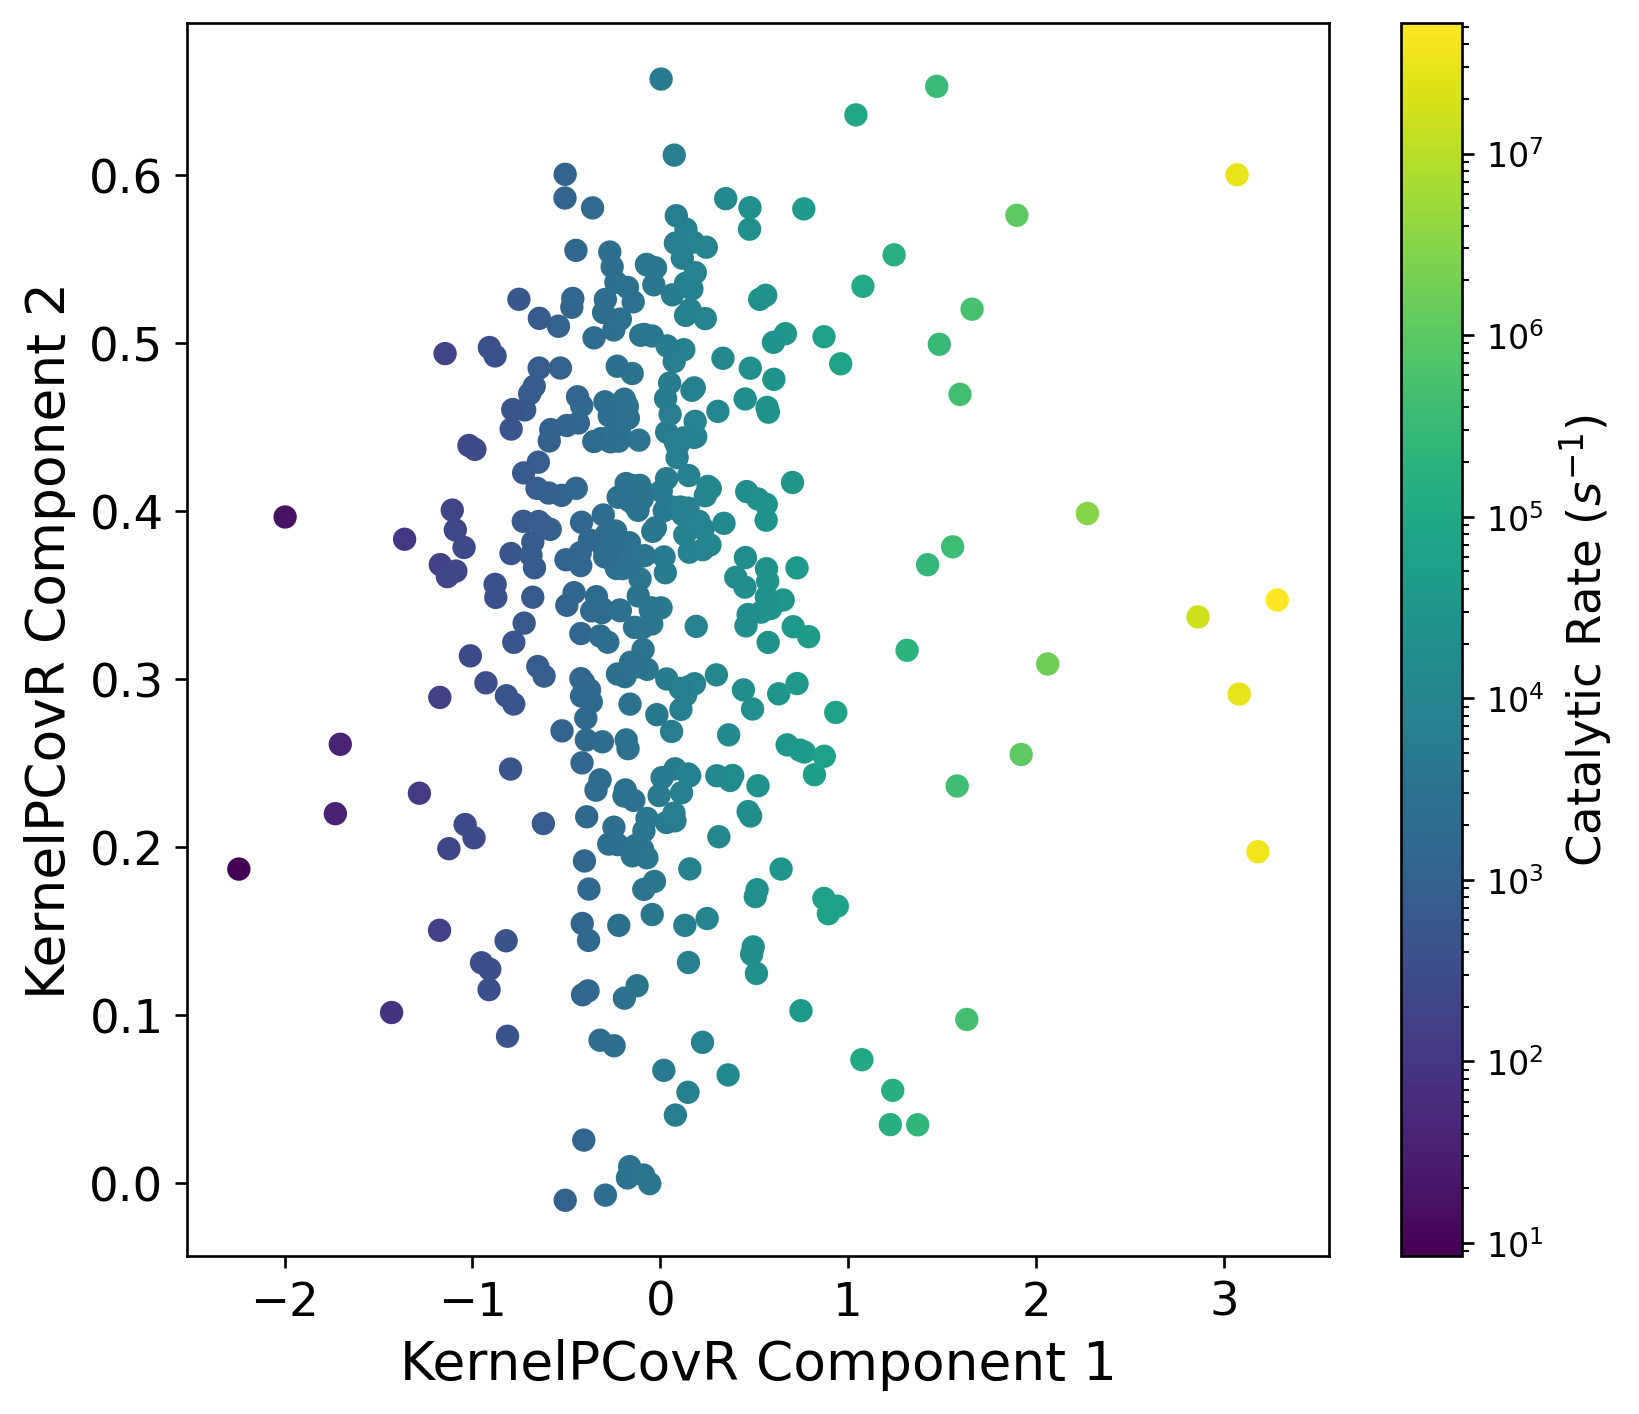

In [35]:
### data v1 ###
plt.figure(figsize = (7, 6))
plt.scatter(X_kpcr_v1[:, 0], X_kpcr_v1[:, 1], c = y_v1,
            norm = LogNorm(), alpha = 1)
#plt.title("KernelPCovR Projection of Site-Structure Features (Version 1)")
cbar = plt.colorbar()
cbar.set_label(label = r"Catalytic Rate ($s^{-1}$)", size=14)
plt.xlabel("KernelPCovR Component 1", fontsize=16)
plt.ylabel("KernelPCovR Component 2", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [36]:
### data_v2 ###
n_features_v2 = X_scaled_v2.shape[1]
gamma_kpcovr = 1/n_features_v2

kernel_params = {
    "kernel": "rbf",
    "gamma": gamma_kpcovr}

regressor = KernelRidge(
    alpha = 1e-10,
    **kernel_params)

kpcovr = KernelPCovR(
    mixing = 0.5,
    n_components = n_features_v2,
    regressor = regressor,
    **kernel_params)

kpcovr.fit(X_scaled_v2, y_log_scaled_v2)
X_kpcr_v2 = kpcovr.transform(X_scaled_v2)
y_kpcr_pred_scaled_v2 = kpcovr.predict(X_scaled_v2)
y_kpcr_pred_log_v2 = y_log_scaler_v2.inverse_transform(y_kpcr_pred_scaled_v2).ravel()
y_kpcr_pred_v2 = 10**y_kpcr_pred_log_v2

In [37]:
r2=r2_score(y_v2, y_kpcr_pred_v2)
mse=mean_squared_error(y_v2, y_kpcr_pred_v2)
print("KPCovR R^2:", round(r2, 10))
print("KPCovR MSE:", round(mse, 3))

KPCovR R^2: 0.9999787653
KPCovR MSE: 339286448.692


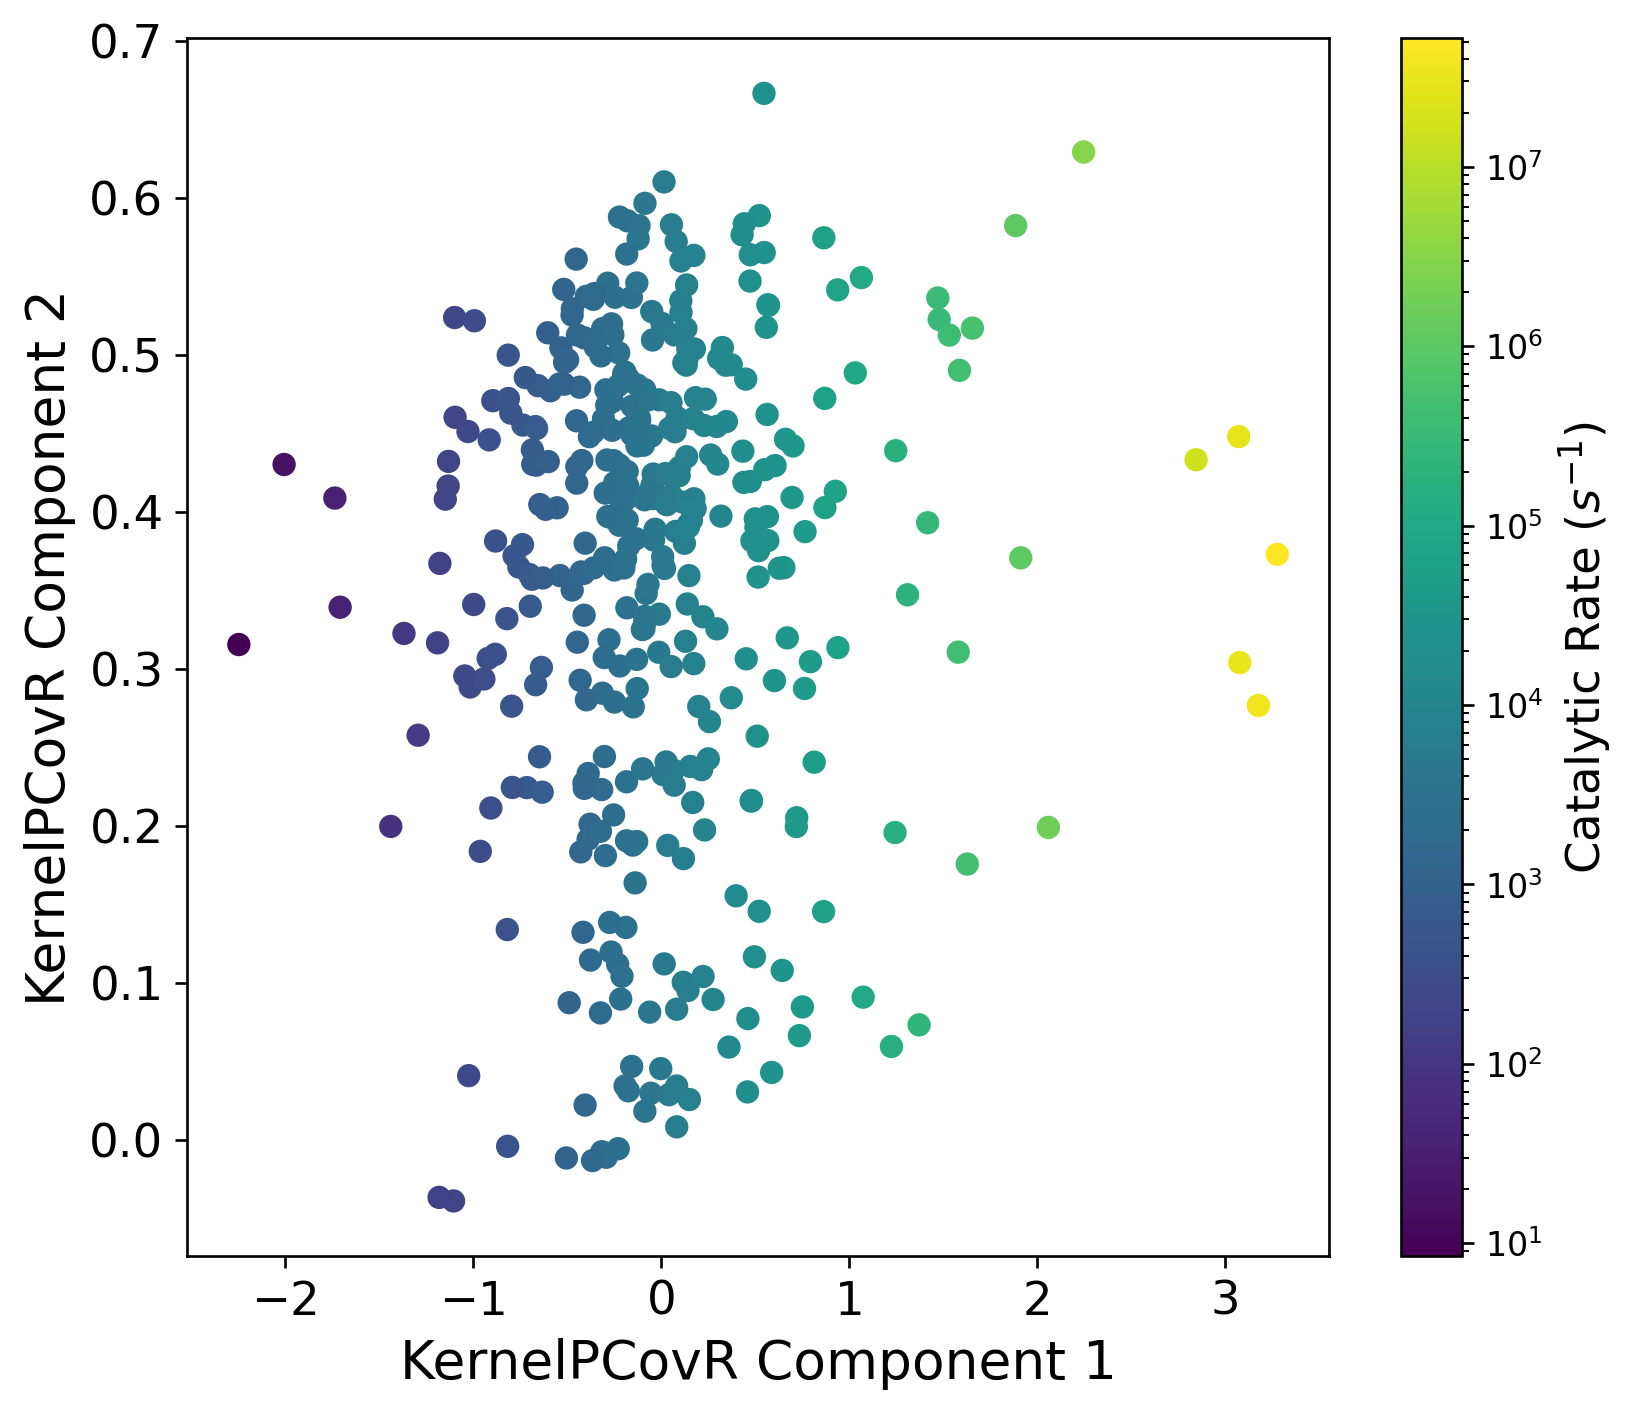

In [38]:
### data v2 ###
plt.figure(figsize = (7, 6))
plt.scatter(X_kpcr_v2[:, 0], X_kpcr_v2[:, 1], c = y_v2,
            norm = LogNorm(), alpha = 1)
cbar = plt.colorbar()
cbar.set_label(label = r"Catalytic Rate ($s^{-1}$)", size=14)
plt.xlabel("KernelPCovR Component 1", fontsize=16)
plt.ylabel("KernelPCovR Component 2", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("KernelPCovR Projection of Site-Structure Features (Version 2)")
plt.tight_layout()
plt.show()